In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

import dask
import xarray as xr
from pathlib import Path
from torch.distributions import Normal
import torch
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from models.autoencoder import Autoencoder, Autoencoder_decoupled, Autoencoder_decoder, MAF, RealNVP
from models.unet import UNet
from models.cnn import CNN, SCNN
from losses import WeightedMSE, WeightedMSESignLoss, WeightedMSEKLD, WeightedMSESignLossKLD, VAEloss
from data_utils.datahandling import combine_observations
from preprocessing import align_data_and_targets, get_coordinate_indices, create_train_mask, reshape_obs_to_data
from preprocessing import AnomaliesScaler_v1, AnomaliesScaler_v2, Standardizer, PreprocessingPipeline, Spatialnanremove, calculate_climatology
from torch_datasets import XArrayDataset
from subregions import subregions
from data_locations import LOC_FORECASTS_fgco2, LOC_OBSERVATIONS_fgco2_v2023
import gc
import pyshtools as pysh
from matplotlib.animation import FuncAnimation

# specify data directories
data_dir_forecast = LOC_FORECASTS_fgco2
data_dir_obs = LOC_OBSERVATIONS_fgco2_v2023
unit_change = 60*60*24*365 * 1000 /12 * -1 ## Change units for ESM data to mol m-2 yr-1


/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/miniconda3/envs/rsaenv_neurips/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def corr_map(ds1, ds2):
        mean1 = ds1.mean(['lat',
                          'lon'])
        mean2 = ds2.mean(['lat',
                          'lon'])
        std1  = ds1.std(['lat',
                         'lon'])
        std2  = ds2.std(['lat',
                         'lon'])
        covariance = ((ds1 - mean1) * (ds2 - mean2)).mean(['lat',
                                                           'lon'])
        return (covariance/(std1 * std2)) #.values


def sample_from_histogram(hist_prob, xedges, yedges, num_samples=500):
    # Flatten the histogram to treat it as a probability distribution
    hist_flat = hist_prob.ravel()

    # Sample bins based on their probability
    bin_indices = np.random.choice(len(hist_flat), p=hist_flat, size=num_samples)

    # Convert flat indices back to 2D bin indices
    bin_x, bin_y = np.unravel_index(bin_indices, hist_prob.shape)

    # Sample uniformly within the chosen bin
    x_samples = np.random.uniform(xedges[bin_x], xedges[bin_x + 1], size=num_samples)
    y_samples = np.random.uniform(yedges[bin_y], yedges[bin_y + 1], size=num_samples)
    
    return x_samples, y_samples

def normal_samples_within_bounds(mean, cov, num_samples, bounds=(-1, 1)):
    samples = []
    while len(samples) < num_samples:
        # Generate a sample from a multivariate normal distribution
        sample = np.random.multivariate_normal(mean, cov)
        # Check if the sample lies within the specified bounds
        if np.all(sample >= bounds[0]) and np.all(sample <= bounds[1]):
            samples.append(sample)
    return np.array(samples)

def torch_normal_sampling( mu, std, num_samples = 1, truncated_dist = None,  ):
    if truncated_dist is not None:
        samples = []
        while len(samples) < num_samples:
            sample =  Normal(mu, std).rsample(sample_shape=(num_samples,))
            # Keep only samples within the bounds
 
            if isinstance(truncated_dist, np.ndarray):
                truncated_dist = torch.from_numpy(truncated_dist)

            sample_dists =  np.sqrt(((sample - sample.mean(axis = 0))**2).sum(-1))
            sample = sample[sample_dists <= truncated_dist]

            samples.append(sample)
        # Concatenate all valid samples and return the required number
        return torch.cat(samples)[:num_samples]
    else:
        z =  Normal(mu, std).rsample(sample_shape=(num_samples,))
        return z
    
    
def normalize(ds):
    return (ds - ds.mean())/ds.std()

In [316]:
# ds_in = xr.open_mfdataset('/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/data/fgco2/simulation/fake_test/fake_normal_historical_ensembles_19501-201412_1x1_LE_pi.nc')['fgco2'].transpose('year','lead_time','ensembles',...)


# Tests ts and maps

In [ ]:
ds_in = xr.open_dataset('/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/data/fgco2/simulation/fake_test/fake_normal_historical_ensembles_19501-201412_1x1_LE_pi.nc')['fgco2'].transpose('year','lead_time','ensembles',...)
ds_full = xr.open_mfdataset('/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/data/fgco2/simulation/fake_test/fake_historical_ensembles_2005-2014_1x1_LE_pi.nc')['fgco2'].transpose('year','lead_time','ensembles',...)
nn_dir = '/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/output/fgco2_ems/SOM-FFN/results/Autoencoder/run_set_8_toy/N2_v0_Banealing_L0_archNone_batch100_e40_cBVAElatentdependant_10-1_MAFpriorNormal_RmEnsMn_hist_fake_data_normal_pi_smallbeta_start10_TSE20/tests'
nn_adjusted = xr.open_mfdataset(str(Path(nn_dir, "*.nc")), combine='nested', concat_dim='year').sel(year = slice(2010,2014)).load()['nn_adjusted']


In [ ]:
plt.figure(figsize = (8,3))
plt.subplot(1,1,1)

start_year = input('start year?')
end_year = input('end_year year?')
dstp = ds_in.sel(year = slice(start_year,end_year))[...,1:-1,1:-1].mean(['lat','lon']).isel(ensembles = np.arange(1,21))
xx = dstp.isel(ensembles = 0).stack(ref = ('year','lead_time')).year.values + (dstp.isel(ensembles = 0).stack(ref = ('year','lead_time')).lead_time.values - 0.5)/12
# for i in range(20):
#     plt.plot(xx, dstp.isel(ensembles = i).stack(ref = ('year','lead_time')))
# plt.plot(xx, dstp.mean('ensembles').stack(ref = ('year','lead_time')), color = 'k')
# plt.title('20 members for training')
# plt.xticks(xx, dstp.isel(ensembles = 0).stack(ref = ('year','lead_time')).ref.values, rotation = 45)
# plt.subplot(3,1,2)
dstp2 = ds_full.sel(year = slice(start_year,end_year))[...,1:-1,1:-1].mean(['lat','lon'])
# for i in range(0,1000,20):
#     plt.plot(xx, dstp2.isel(ensembles = i).stack(ref = ('year','lead_time')))
# plt.plot(np.arange(24), dstp2.mean('ensembles').stack(ref = ('year','lead_time')), color = 'k')
# plt.title('1000 members full dataset')
plt.subplot(1,1,1)
if 'year' in nn_adjusted.dims:
    dstp3 = nn_adjusted.sel(year = slice(start_year,end_year))[...,1:-1,1:-1].mean(['lat','lon']).stack(ref = ('year','lead_time')).squeeze()
else:
    dstp3 = nn_adjusted[...,1:-1,1:-1].mean(['lat','lon']).squeeze()
plt.plot(xx, dstp.mean('ensembles').stack(ref = ('year','lead_time')), label = '20 members training data')
# plt.plot(xx, dstp2.mean('ensembles').stack(ref = ('year','lead_time')), label = '1000 members full data')
plt.plot(xx, dstp3.mean('ensembles'), label = f'{len(nn_adjusted.ensembles)} VAE output')
plt.xticks(xx, dstp.isel(ensembles = 0).stack(ref = ('year','lead_time')).ref.values, rotation = 45)
plt.title('Ensemble mean')
plt.legend()

In [ ]:
plt.figure(figsize = (8,3))
plt.subplot(1,1,1)

dstp = ds_in.sel(year = slice(start_year,end_year)).isel(ensembles = np.arange(1,21)).std('ensembles').mean(['lat','lon'])
xx = dstp.stack(ref = ('year','lead_time')).year.values + (dstp.stack(ref = ('year','lead_time')).lead_time.values - 0.5)/12
# plt.plot(xx, dstp.std('ensembles').stack(ref = ('year','lead_time')), color = 'k')
# plt.title('20 members for training')
# plt.xticks(xx, dstp.isel(ensembles = 0).stack(ref = ('year','lead_time')).ref.values, rotation = 45)
# plt.subplot(3,1,2)
dstp2 = ds_full.sel(year = slice(start_year,end_year)).std('ensembles').mean(['lat','lon'])
# plt.plot(np.arange(24), dstp2.std('ensembles').stack(ref = ('year','lead_time')), color = 'k')
# plt.title('1000 members full dataset')
# plt.subplot(3,1,1)
if 'year' in nn_adjusted.dims:
    dstp3 = nn_adjusted.sel(year = slice(start_year,end_year)).std('ensembles').mean(['lat','lon']).stack(ref = ('year','lead_time')).squeeze()
else:
    dstp3 = nn_adjusted.std('ensembles').std('ensembles')[...,1:-1,1:-1].mean(['lat','lon']).squeeze()
plt.plot(xx, dstp.stack(ref = ('year','lead_time')), label = '20 members training data')
plt.plot(xx, dstp2.stack(ref = ('year','lead_time')), label = '1000 members full data')
plt.plot(xx, dstp3, label = f'{len(nn_adjusted.ensembles)} VAE output')
plt.xticks(xx, dstp.stack(ref = ('year','lead_time')).ref.values, rotation = 45)
plt.title('Ensemble std')
plt.legend()

In [ ]:
plt.figure(figsize = (10,13))
year = int(input('year?'))
lead_time = int(input('lead_time?'))

dstp = ds_in.sel(year = slice(year,year), lead_time = lead_time).sel(ensembles = np.arange(1,21))[...,1:-1,1:-1]
plt.subplot(3,2,1)
dstp.mean('ensembles').plot()
plt.title(f'{year} {lead_time} \n Train data {len(dstp.ensembles)} members mean')
# plt.xlabel('')

plt.subplot(3,2,2)
ref =  ds_full.sel(year = slice(year,year), lead_time = lead_time).std('ensembles')
dstp.std('ensembles').plot()
corr = corr_map(ref, dstp.std('ensembles')).values
plt.title(f'Train data {len(dstp.ensembles)} members grid wise std ({np.round(corr,2)})')
plt.xlabel('')
plt.ylabel('')



dstp = ds_full.sel(year = slice(year,year), lead_time = lead_time)[...,1:-1,1:-1]
plt.subplot(3,2,3)
dstp.mean('ensembles').plot()
plt.title(f'ds_full {len(dstp.ensembles)} members mean')
plt.xlabel('')
plt.subplot(3,2,4)
dstp.std('ensembles').plot()
corr = corr_map(ref, dstp.std('ensembles')).values
plt.title(f'ds_full {len(dstp.ensembles)} members grid wise std ({np.round(corr,2)})')
plt.xlabel('')
plt.ylabel('')



dstp = nn_adjusted.sel(year = slice(year,year), lead_time = lead_time).squeeze()[...,1:-1,1:-1]
plt.subplot(3,2,5)

dstp.mean('ensembles').plot()
plt.title(f'nn {len(dstp.ensembles)} members mean')
plt.subplot(3,2,6)
dstp.std('ensembles').plot()
corr = corr_map(ref, dstp.std('ensembles')).values
plt.title(f'nn {len(dstp.ensembles)} members grid wise std ({np.round(corr,2)})')
plt.ylabel('')


In [ ]:
plt.figure(figsize = (50,50))
for ind, i in enumerate(range(0,200)):
    plt.subplot(15,15,ind+1)
    nn_adjusted.sel(year = slice(year,year), lead_time = lead_time).isel(ensembles = i).plot()

In [ ]:
plt.figure(figsize = (50,50))
for i in range(49):
    plt.subplot(7,7,i+1)
    ds_in.sel(year = slice(year,year), lead_time = lead_time).isel(ensembles = i).plot()

In [ ]:
plt.figure(figsize = (50,50))
for i in range(200):
    plt.subplot(15,15,i+1)
    ds_full.sel(year = slice(year,year), lead_time = lead_time).isel(ensembles = i).plot()

In [ ]:
from preprocessing import power, plot_power
ds_dict = {}
for i in ds_in.sel(ensembles = np.arange(1,21)).ensembles.values:
    ds_dict[i] = ds_in.sel(year = slice(year,year), lead_time = lead_time).sel(ensembles = i)[...,1:-1,1:-1].squeeze()
plot_power(ds_dict, title = f'Power Spectral density {year}-{lead_time} ds_in {len(ds_in.sel(ensembles = np.arange(1,21)).ensembles)}', legend = False)

# ds_dict = {}
# for i in range(len(ds_full.ensembles)):
#     ds_dict[i] = ds_full.sel(year = slice(year,year), lead_time = lead_time).isel(ensembles = i).squeeze()
# plot_power(ds_dict, title = f'Power Spectral density {year}{lead_time} ds_full {len(ds_full.ensembles)}', legend = False)


ds_dict = {}
for i in range(len(nn_adjusted.ensembles)):
    ds_dict[i] = nn_adjusted.sel(year = slice(year,year), lead_time = lead_time).isel(ensembles = i)[...,1:-1,1:-1].squeeze()
plot_power(ds_dict, title = f'Power Spectral density {year}-{lead_time} nn_adjusted {len(nn_adjusted.ensembles)}', legend = False)

In [1192]:
year = 2013
lead_time = 5

In [ ]:
from preprocessing import power, plot_power
ds_dict = []
for i in ds_in.sel(ensembles = np.arange(1,21)).ensembles.values:
    spectrum, wavelengths_km = power(ds_in.sel(year = slice(year,year), lead_time = lead_time).sel(ensembles = i)[...,1:-1,1:-1].squeeze())
    ds_dict.append(spectrum)

plt.plot(wavelengths_km, np.log2(np.mean(ds_dict,0)), label=f'ds_in {len(ds_in.sel(ensembles = np.arange(1,21)).ensembles)} members')

# ds_dict = []
# for i in range(len(ds_full.ensembles)):
#     spectrum, wavelengths_km = power(ds_full.sel(year = slice(year,year), lead_time = lead_time).isel(ensembles = i).squeeze())
#     ds_dict.append(spectrum)
# plt.plot(wavelengths_km, np.log2(np.mean(ds_dict,0)), label=f'ds_full {len(ds_full.ensembles)} members')


ds_dict = []
for i in range(len(nn_adjusted.ensembles)):
    spectrum, wavelengths_km = power(nn_adjusted.sel(year = slice(year,year), lead_time = lead_time).isel(ensembles = i)[...,1:-1,1:-1].squeeze())
    ds_dict.append(spectrum)
plt.plot(wavelengths_km,  np.log2(np.mean(ds_dict,0)), label=f'nn_boosted {len(nn_adjusted.ensembles)} members')


plt.xscale('log')
plt.xlabel('Wavelength (km)')
plt.ylabel(f'Log$_2$ Power')

plt.grid(True)
plt.legend()
plt.gca().invert_xaxis()  # Invert the x-axis since larger wavelengths correspond to smaller l-values
plt.show()



In [ ]:
ds_dict = {'ds_in EM' :  ds_in.sel(ensembles = np.arange(1,21)).sel(year = slice(year,year), lead_time = lead_time).mean('ensembles')[...,1:-1,1:-1].squeeze(),
# 'ds_full' : ds_full.sel(year = slice(year,year), lead_time = lead_time).mean('ensembles').squeeze(),
'nn_adjusted EM' :  nn_adjusted.sel(year = slice(year,year), lead_time = lead_time).mean('ensembles')[...,1:-1,1:-1].squeeze()}

plot_power(ds_dict, title = f'Power Spectral density {year} {lead_time}')

# Latent breakdown

In [746]:

import glob
def extract_params(model_dir):
    params = {}
    path = glob.glob(model_dir + '/*.txt')[0]
    file = open(path)
    content=file.readlines()
    for line in content:
        key = line.split('\t')[0]
        try:
            value = line.split('\t')[1].split('\n')[0]
        except:
            value = line.split('\t')[1]
        try:    
            params[key] = eval(value)
        except:
            if key == 'ensemble_list':
                ls = []
                for item in value.split('[')[1].split(']')[0].split(' '):
                    try:
                        ls.append(eval(item))
                    except:
                        pass
                params[key] = ls
            else:
                params[key] = value
    return params


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [747]:
params = extract_params(nn_dir)
params['BVAE'] = int(nn_dir.split('-')[-2][-2:])
hyperparam = params["hyperparam"]
reg_scale = params["reg_scale"]
model = params["model"]
hidden_dims = params["hidden_dims"]
time_features = params["time_features"]
epochs = params["epochs"]
batch_size = params["batch_size"]
dropout_rate = params["dropout_rate"]
condition_embedding_size = params['condition_embedding_size']

extra_predictors = params['extra_predictors']
batch_normalization = params['batch_normalization']

try:
    version = int(nn_dir.split('/')[-1].split('_')[1][1])
except:
    version = (nn_dir.split('/')[-1].split('_')[1][1:])
    
params["version"] = version

if params['version'] == 1:
        
        params['forecast_preprocessing_steps'] = [
        ('standardize', Standardizer())]
        params['forecast_ensemble_mean_preprocessing_steps'] = [
        ('standardize', Standardizer())]
        params['observations_preprocessing_steps'] = []

elif params['version'] == 2:

        params['forecast_preprocessing_steps'] = [
        ('standardize', Standardizer(axis = (0,2)))]
        params['forecast_ensemble_mean_preprocessing_steps'] = [
        ('standardize', Standardizer(axis = (0,)))]
        params['observations_preprocessing_steps'] = []

forecast_preprocessing_steps = params["forecast_preprocessing_steps"]
forecast_ensemble_mean_preprocessing_steps = params["forecast_ensemble_mean_preprocessing_steps"]
observations_preprocessing_steps = params["observations_preprocessing_steps"]

if 'CrMmbrTr' in  nn_dir:
    params['cross_member_training'] = True 
else:
    params['cross_member_training'] = False 

if 'RmEnsMn' in  nn_dir:
    params['remove_ensemble_mean'] = True 
else:
    params['remove_ensemble_mean'] = False 

if 'cEFullBVAE' in  nn_dir:
    params['full_conditioning'] = True 
else:
    params['full_conditioning'] = False 

if 'Correction' in  nn_dir:
    params['correction'] =  True
else:
    params['correction'] = False 

if 'latentdependant' in  nn_dir:
    params['condition_dependant_latent'] = True
    assert params['condition_embedding_size'] is not None
    params['non_random_decoder_initialization'] = True
else: 
    params['condition_dependant_latent'] = False

if 'LY' in nn_dir:
    lead_time = int(out_dir.split('LY')[1][0])
else:
    lead_time = None
if 'pR' not in  nn_dir:
    params['min_posterior_variance'] =  None
else:
    params['min_posterior_variance'] =  np.array(params['min_posterior_variance'])

condition_embedding_size = params['condition_embedding_size']
conditional_embedding = True if condition_embedding_size is not None else False

In [748]:
model_year = 49

In [776]:

var = 'tas'
data_dir_forecast = "/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/data/tas/piControl/tas_piControl_LE_0101-5112.nc"

ds_in = xr.open_dataset(data_dir_forecast).load()[var]
ds_in = ds_in.expand_dims('channels', axis=3).sortby('ensembles')   
ds_raw_ensemble = ds_in.transpose('year','lead_time','ensembles',...)
del ds_in
gc.collect()

train_years = ds_raw_ensemble.year[ds_raw_ensemble.year < model_year + 1].to_numpy()
n_train = len(train_years)
ds_baseline = ds_raw_ensemble[:n_train,...]
train_mask = create_train_mask(ds_raw_ensemble[:n_train,...])

if 'ensembles' in ds_raw_ensemble.dims: ## PG: Broadcast the mask to the correct shape if you have an ensembles dim.
    preprocessing_mask_fct = np.broadcast_to(train_mask[...,None,None,None,None], ds_baseline.shape)
else:
    preprocessing_mask_fct = np.broadcast_to(train_mask[...,None,None,None], ds_baseline.shape)



ds_em = ds_raw_ensemble.sel(ensembles = params['ensemble_list']).mean('ensembles')
if params['remove_ensemble_mean']:  
    ds = ds_raw_ensemble - ds_raw_ensemble.mean('ensembles')
else:
    ds =  ds_raw_ensemble.copy()

ds_pipeline = PreprocessingPipeline(forecast_preprocessing_steps).fit(ds[:n_train,...], mask=preprocessing_mask_fct)
ds = ds_pipeline.transform(ds)

ds_em_pipeline = PreprocessingPipeline(forecast_ensemble_mean_preprocessing_steps).fit(ds_em[:n_train,...], mask=preprocessing_mask_fct[:,:,0,...])
ds_em = ds_em_pipeline.transform(ds_em)
  
###
year_max = ds[:n_train + 1].year[-1].values 

del ds_baseline, preprocessing_mask_fct, 
gc.collect()

ds_train_ = ds[:n_train,...]


if conditional_embedding:
    if params['condition_type'] == 'climatology':
                    ds_em = xr.concat([ds_em.mean(['year']).expand_dims('year', axis = 0) for _ in range(len(ds_em.year))], dim = 'year').assign_coords(year = ds_em.year.values)
    ds_train_conds_ = ds_em.sel(year = ds_train_.year).stack(time=('year','lead_time')).transpose('time',...)[~train_mask.flatten()]
    if lead_time is not None:
        ds_train_conds_ = ds_train_conds_.where((ds_train_conds_.lead_time >=  (lead_time - 1) * 12 + 1) & (ds_train_conds_.lead_time < (lead_time *12 )+1), drop = True)

     


In [777]:
ds_train = ds_train_.copy()
if conditional_embedding:
    ds_train_conds = ds_train_conds_.copy()


img_dim = ds_train.shape[-2] * ds_train.shape[-1] 

if time_features is None:
        add_feature_dim = 0
else:
        add_feature_dim = len(time_features)
if extra_predictors is not None:
    add_feature_dim = add_feature_dim + len(params['extra_predictors'])

try:       
    if params['prior_flow'] is not None:
        dics = {}
        if len((params['prior_flow'].split('args'))) > 0:
            pass
        
        dics['num_layers'] = eval((params['prior_flow'].split('num_layers'))[-1].split(',')[0].split(':')[-1]) 
        try: 
            dics['base_distribution'] = eval((params['prior_flow'].split('base_distribution'))[-1].split('}')[0].split(':')[-1])  
        except:
             pass
        dics['type'] = eval(nn_dir.split('prior')[0].split('_')[-1])
        params['prior_flow'] = dics
except:
     params['prior_flow'] = None

In [751]:
# model = Autoencoder
# params['prior_flow'] = {}
# params['prior_flow']['type'] = MAF
# params['prior_flow']['num_layers'] = 5


In [752]:
params['condemb_to_decoder'] = False
params['full_conditioning'] = False

In [778]:

latent_dim = hidden_dims[0][-1]
net = model(img_dim, hidden_dims[0], hidden_dims[1], added_features_dim=add_feature_dim, append_mode=params['append_mode'], batch_normalization=batch_normalization, dropout_rate=dropout_rate, VAE = params['BVAE'], condition_embedding_dims = params['condition_embedding_size'], full_conditioning = params['full_conditioning'], condition_dependant_latent = params["condition_dependant_latent"], min_posterior_variance = (params['min_posterior_variance']), prior_flow = params['prior_flow'], condemb_to_decoder = params['condemb_to_decoder'] ,device = device)
net.load_state_dict(torch.load(glob.glob(nn_dir+ '/Saved_models' + f'/*-{model_year}*.pth')[0], map_location=torch.device('cpu')))               
net.to(device)
net.eval()

IndexError: list index out of range

In [779]:
ds_train = ds_train.stack(time = ('year','lead_time')).stack(ref = ('lat','lon')).transpose('time','ensembles',...,'ref')
if conditional_embedding:
    ds_train_conds = ds_train_conds.stack(ref = ('lat','lon')).transpose('time',...,'ref')
if time_features is not None:
    time_features_list = np.array([time_features]).flatten()
    feature_indices = {'year': 0, 'lead_time': 1, 'month_sin': 2, 'month_cos': 3, 'sin_t' : 4, 'cos_t' : 5}
    y = (ds_train.year.to_numpy() + np.floor(ds_train.lead_time.to_numpy()/12)) / year_max
    t =  np.arange(len(ds_train.year))
    lt = ds_train.lead_time.to_numpy() / np.max(ds_train.lead_time.to_numpy())
    tsin = np.sin(t)
    tcos = np.cos(t)
    msin = np.sin(2 * np.pi * ds_train.lead_time/12.0)
    mcos = np.cos(2 * np.pi * ds_train.lead_time/12.0)
    time_features = np.stack([y, lt, msin, mcos, tsin, tcos], axis=1)
    time_features = time_features[..., [feature_indices[k] for k in time_features_list]]

ds_mu = xr.concat([xr.full_like(ds_train[...,-1].squeeze().drop(['ref','lat','lon']), np.NAN) for _ in range(latent_dim)],dim = 'mu').transpose('time','ensembles',...,'mu').rename('latent')
ds_var = ds_mu.copy()
ds_samples = ds_mu.copy()
ds_emb = None
if params['condition_dependant_latent']:
    if params['prior_flow'] is None:
        ds_mu_cond = xr.concat([xr.full_like(ds_train_conds[...,-1].squeeze().drop(['ref','lat','lon']), np.NAN) for _ in range(latent_dim)],dim = 'mu').transpose('time',...,'mu').rename('latent')
        ds_var_cond = ds_mu_cond.copy()
    if any([params['condemb_to_decoder'], params['prior_flow'] is not None]):
        ds_emb = xr.concat([xr.full_like(ds_train_conds[...,-1].squeeze().drop(['ref','lat','lon']), np.NAN) for _ in range(net.embedding_size)],dim = 'mu').transpose('time',...,'mu').rename('latent')
else:
    if params['condemb_to_decoder']:
        ds_emb = xr.concat([xr.full_like(ds_train_conds[...,-1].squeeze().drop(['ref','lat','lon']), np.NAN) for _ in range(net.embedding_size)],dim = 'mu').transpose('time',...,'mu').rename('latent')



In [663]:
# ds_samples  =xr.concat([ds_samples.expand_dims('samples', axis = 1) for _ in range(100)], dim = 'samples')

In [780]:
np.random.seed(1)
torch.manual_seed(1)

for t in range(len(ds_train.time)):
    x_in = torch.from_numpy(ds_train[t].data).to(torch.float32)
    if conditional_embedding:
        cond = torch.from_numpy(ds_train_conds.isel(time = t).data).to(torch.float32)

        if params['condition_dependant_latent']:
            if all([params['prior_flow'] is None,params['condemb_to_decoder']])  :
                ds_emb[t,:] = net.condition_mu(net.embedding(cond.flatten(start_dim=1))).detach().numpy().squeeze()
            elif params['prior_flow'] is not None:
                ds_emb[t,:] = (net.embedding(cond.flatten(start_dim=1))).detach().numpy().squeeze()

        elif params['condemb_to_decoder']:
            ds_emb[t,:] = net.embedding(cond.flatten(start_dim=1)).detach().numpy().squeeze()
            
        cond = cond.unsqueeze(0).expand_as(x_in)
    else:
        cond = None

    if all([time_features is not None, params['append_mode'] in [1,3]]):
        tf = torch.from_numpy(time_features[t][None,]).to(torch.float32)
        x_in = (x_in, tf.expand(x_in.shape[0], add_feature_dim))
    
    with torch.no_grad():
        mu , log_var = net(x_in, condition = cond, sample_size = 1)[1:3]
        ds_samples[t,:,:] = net.sample(mu, log_var, 1 )[0]
        ds_mu[t,:,:] = mu
        # ds_var[t,:,:] = torch.exp(net(x_in, condition = cond, sample_size = 1)[2] + 1e-4)
        

        if params['condition_dependant_latent']:
            if params['prior_flow'] is None:
                ds_mu_cond[t,:] = net.condition_mu(net.embedding(torch.from_numpy(ds_train_conds.isel(time = t).data).to(torch.float32))).squeeze()
                ds_var_cond[t,:] = torch.exp(net.condition_log_var(net.embedding(torch.from_numpy(ds_train_conds.isel(time = t).data).to(torch.float32))).squeeze()) + 1e-4


In [756]:
from sklearn.decomposition import PCA
def doPCA(ds, n_components=2,  fitted_pca = None, return_explained_variance = True):
    assert n_components < len(ds.mu)
    ds_ =ds.isel(mu = np.arange(n_components))
    if fitted_pca is None:
        pca = PCA(n_components=n_components)
    else:
        pca = fitted_pca
    if 'ensembles' in ds.dims:
        ds_out = xr.zeros_like(ds_)
        ds_out_flat = xr.zeros_like(ds_.reset_index(('lead_time')).assign_coords(time = np.arange(0,len(ds_.reset_index('lead_time').time))).stack(d = ('time','ensembles')).transpose(...,'mu'))
        if fitted_pca is None:
            ds_out_flat[:] = pca.fit_transform(ds.reset_index(('lead_time')).assign_coords(time = np.arange(0,len(ds_.reset_index('lead_time').time))).stack(d = ('time','ensembles')).transpose(...,'mu').values)
        else:
            ds_out_flat[:] = pca.transform(ds.reset_index(('lead_time')).assign_coords(time = np.arange(0,len(ds_.reset_index('lead_time').time))).stack(d = ('time','ensembles')).transpose(...,'mu').values)
        ds_out[:] = ds_out_flat.unstack('d').transpose(...,'ensembles','mu').values
    else:
        ds_out = xr.zeros_like(ds_)
        if fitted_pca is None:
            ds_out[:]  = pca.fit_transform(ds.values)
        else:
            ds_out[:]  = pca.transform(ds.values)
    if return_explained_variance:
        return ds_out,pca, pca.explained_variance_ratio_
    else:
        return ds_out, pca


In [757]:

if net.latent_size >2:

    PCAs = {}
    ds_samples,PCAs['samples'], explained_variance_ratio_ = doPCA(ds_samples)
    print(f'ds_samples explained ratio : {explained_variance_ratio_}')
    ds_mu,pca,  explained_variance_ratio_ = doPCA(ds_mu, fitted_pca = PCAs['samples'])
    print(f'ds_mu explained ratio : {explained_variance_ratio_}')

    if ds_emb is not None:
        ds_emb, PCAs['emb'], explained_variance_ratio_ = doPCA(ds_emb)
        print(f'ds_emb explained ratio : {explained_variance_ratio_}')

    

ds_samples explained ratio : [0.07316698 0.06548716]
ds_mu explained ratio : [0.07316698 0.06548716]


In [758]:
# mu , log_var = net(x_in, condition = cond, sample_size = 1)[1:3]
# samples = net.sample(mu, log_var, 100 )
# if net.latent_size >2 :
#         pca = PCAs['samples]
#         samples = pca.fit_transform(samples.flatten(start_dim= 0 , end_dim=1))
# plt.scatter(samples[:,0].detach().numpy(),samples[:,1].detach().numpy(), alpha = 0.5,marker = 'x', label = 'data samples')

# samples = Normal(torch.mean(samples, (0,1)), torch.std(samples, (0,1))).rsample(sample_shape=(10000,))
# if net.latent_size >2 :
#         samples = pca.fit_transform(samples)
# plt.scatter(samples[:,0].detach().numpy(),samples[:,1].detach().numpy(), alpha = 0.5,marker = 'x', label = 'Normal dist.')

In [526]:
# ds_samples = ds_samples.stack(members = ('samples','ensembles')).transpose('time','members','mu')

(array([8.000e+00, 1.040e+02, 6.230e+02, 2.365e+03, 4.314e+03, 3.401e+03,
        1.290e+03, 2.200e+02, 2.000e+01, 3.000e+00]),
 array([-4.98154545, -3.88653865, -2.79153185, -1.69652505, -0.60151825,
         0.49348855,  1.58849535,  2.68350215,  3.77850895,  4.87351575,
         5.96852255]),
 <BarContainer object of 10 artists>)

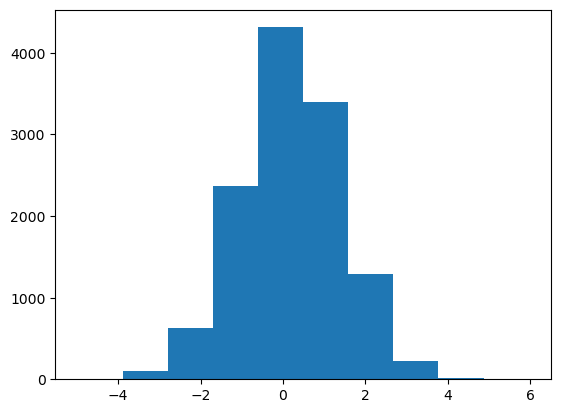

In [795]:
plt.hist(ds_samples.data.reshape(-1,500)[:,400])

In [792]:
ds_samples.data.reshape(-1,500)

array([[-0.55684698,  0.53147429, -0.29928231, ...,  0.86476564,
        -0.90547013,  1.24458623],
       [-3.79164028, -0.14170748, -0.02089252, ...,  1.03296745,
        -0.13941237,  0.20778051],
       [-1.04403853,  0.12808727, -1.17019439, ...,  0.4853313 ,
         0.67480195, -1.46642637],
       ...,
       [ 0.13526398,  1.78776729,  0.18259652, ..., -0.09618667,
         1.67508245, -0.19449979],
       [-1.78953016, -0.25563142,  0.46616945, ..., -0.45560896,
        -0.9226675 ,  0.75084919],
       [-1.27487493, -0.14618373,  0.64235723, ...,  1.0316726 ,
         1.48431599, -0.68035048]])

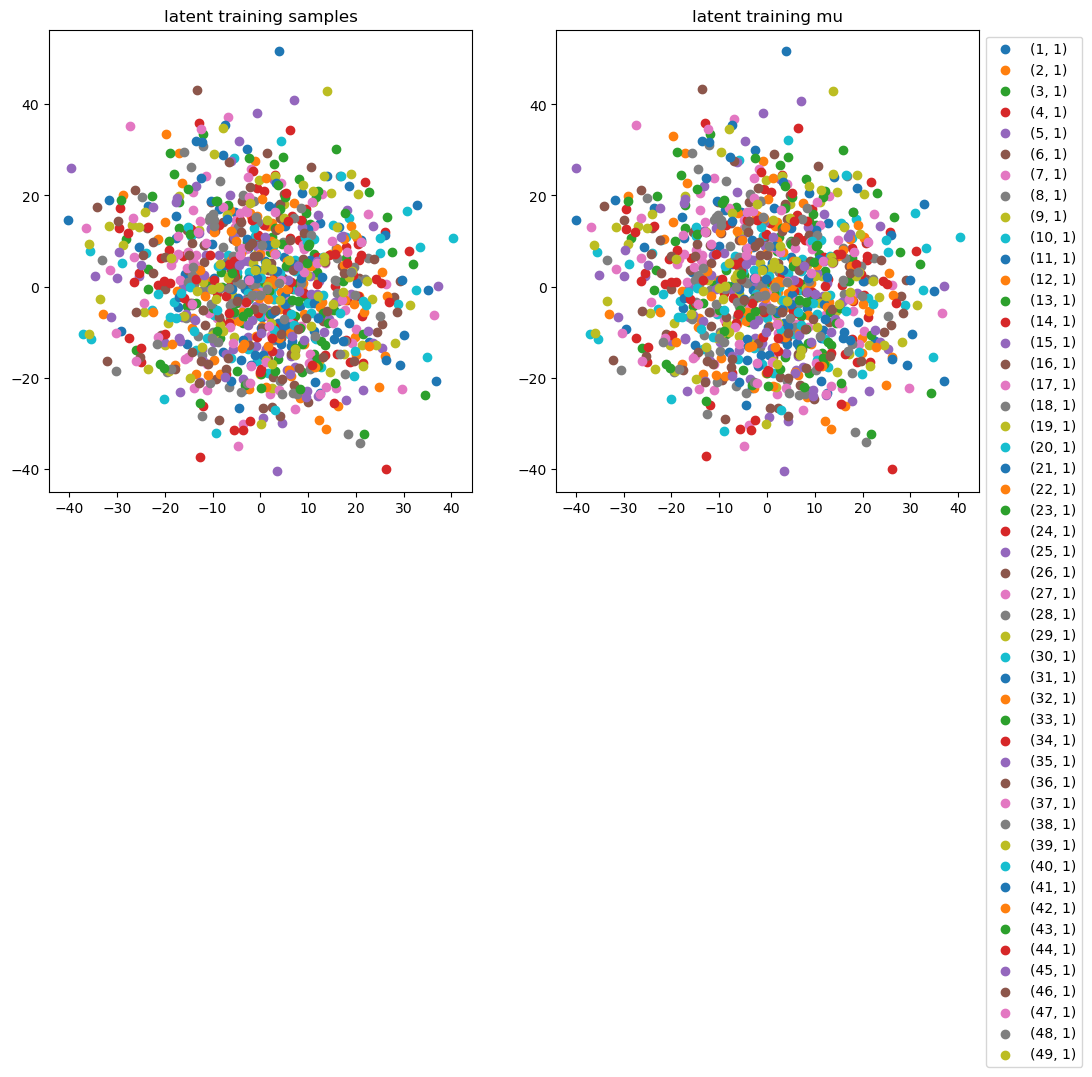

In [759]:
plt.figure(figsize=(12,6))
month_idx = 0
for t in range(0,len(ds_train.time),12):
    plt.subplot(1,2,1)
    plt.scatter(ds_samples[t+month_idx,:,0].values, ds_samples[t+month_idx,:,1].values, label = f'{ds_mu.time[t+month_idx].values}')

    plt.subplot(1,2,2)      
    plt.scatter(ds_mu[t+month_idx,:,0].values, ds_mu[t+month_idx,:,1].values, label = f'{ds_mu.time[t+month_idx].values}')
plt.subplot(1,2,1)
plt.title('latent training samples')

plt.subplot(1,2,2) 
plt.title('latent training mu')
plt.legend(bbox_to_anchor = (1,1))
# cov = torch.eye(2)
# mean = torch.zeros(2)
# plt.subplot(1,2,1)
# samples = np.random.multivariate_normal(mean, cov, size=1000)
# plt.scatter(samples[:,0], samples[:,1], alpha = 0.5, marker = 'x')

In [760]:
if ds_emb is not None:
    for t in range(0,len(ds_train.time)):
        plt.scatter(ds_emb[t,0].values, ds_emb[t,1].values, label = f'{ds_mu.time[t].values}')
         
# plt.legend(bbox_to_anchor = (1,1))

In [761]:

if params['prior_flow'] is not None:
    for t in range(0,len(ds_train.time),100):
        plt.figure(figsize = (10,5))
        std = torch.eye(net.latent_size)
        mean = torch.zeros(net.latent_size)
        samples = Normal(torch.from_numpy(mean), torch.from_numpy(std)).rsample( (1000,))
        # samples = torch.distributions.Uniform(torch.ones(2) * -1 , torch.ones(2)).rsample(sample_shape=(1000,)).numpy()
        x, y = samples.T
        plt.subplot(1,2,1)
        plt.scatter(x, y, alpha=0.5, marker='o')
        plt.title(f'Prior base distribution')

        if params['condition_dependant_latent']:
            condition = torch.from_numpy(ds_emb[t].data[None,]).to(torch.float32).expand(1000,net.embedding_size )
        else:
            condition  = None

        samples_flow = net.flow.inverse((samples).to(torch.float32), condition = condition)[0].detach().numpy()

        if net.latent_size>2:
            samples_flow = PCAs['samples'].transform(samples_flow)
        
        plt.subplot(1,2,2)
        x, y = samples_flow.T
        plt.scatter(x, y, alpha=0.5, marker='o')
        if params['condition_dependant_latent']:
            plt.title(f'tranformed conditional prior distribution \n {ds_mu.time[t].values} ')
        else:
            plt.title(f'tranformed prior distribution ')
        plt.xlabel('X-axis (variable 1)')
        plt.ylabel('Y-axis (variable 2)')
        plt.grid(True)
        plt.show()
        if not params['condition_dependant_latent']:
            break

In [762]:
if params['condition_dependant_latent']:
    flow = 'off'
    for t in range(0,len(ds_train.time),100):
        if params['prior_flow'] is None:
            std = np.array([np.sqrt(ds_var_cond[t,i].values) for i in range(net.latent_size)])
            mean = np.array([ds_mu_cond[t,i].values for i in range(net.latent_size) ])
        else:
            std = np.ones(net.latent_size)
            mean = np.zeros(net.latent_size)

        samples = Normal(torch.from_numpy(mean), torch.from_numpy(std)).rsample( (1000,))

        if params['prior_flow'] is not None:
            flow = 'On'
            condition = torch.from_numpy(ds_emb[t].data[None,]).to(torch.float32).expand(1000,net.embedding_size )
            samples = net.flow.inverse((samples).to(torch.float32), condition = condition)[0].detach().numpy()

        if net.latent_size>2:
            samples = PCAs['samples'].transform(samples)

# Separate the samples into x and y coordinates
        x, y = samples.T

        # Create a scatter plot
        plt.scatter(x, y, alpha=0.5, marker='o', label = f'conditional prior distribution flow {flow}')
        if net.latent_size>2:
            plt.scatter(PCAs['samples'].transform(mean.reshape(1,-1))[0,0], PCAs['samples'].transform(mean.reshape(1,-1))[0,1], color = 'r', label = 'base distribution mean')
        else:
            plt.scatter(mean[0], mean[1], color = 'r', label = 'base distribution mean')
        plt.title(f'Conditional Prior Distribution at time {ds_mu.time[t].values} ')
        plt.scatter(ds_samples[t,:,0].values, ds_samples[t,:,1].values, marker='x', color = 'g', label = f'Posterior model samples for each member')
        plt.xlabel('X-axis (variable 1)')
        plt.ylabel('Y-axis (variable 2)')
        plt.grid(True)
        plt.legend()
        plt.show()

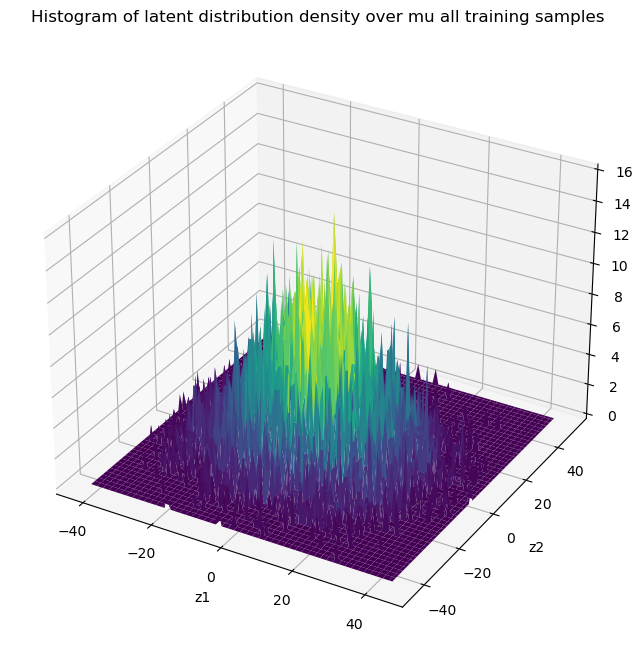

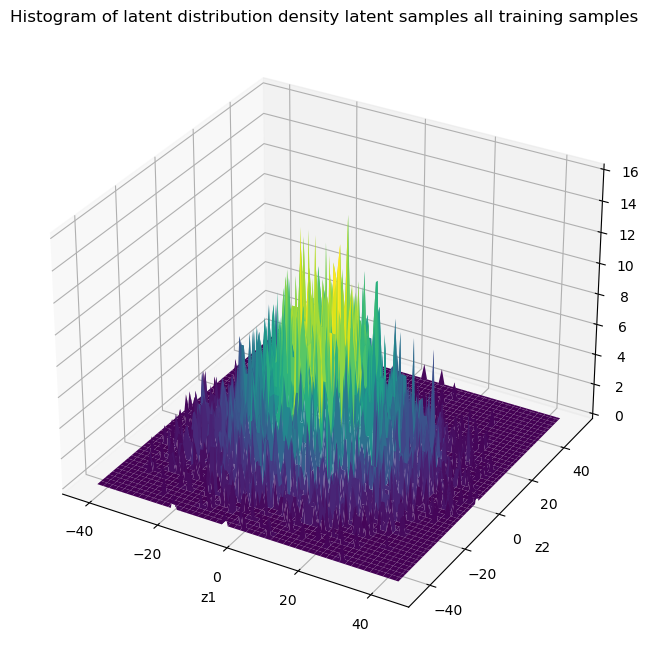

In [763]:

def tweod_hist_plot(data, title = ''):
    hist, xedges, yedges = np.histogram2d(data[:,0], data[:,1], bins=100)
    hist_prob = hist / hist.sum()

    # Create the meshgrid for the bin edges
    xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")

    # Calculate the bin centers (for plotting the surface at the middle of each bin)
    xpos_centers = (xedges[:-1] + xedges[1:]) / 2
    ypos_centers = (yedges[:-1] + yedges[1:]) / 2

    # Create a meshgrid of the bin centers
    xpos_centered, ypos_centered = np.meshgrid(xpos_centers, ypos_centers)

    # Create the figure and a 3D axis
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot a surface plot
    ax.plot_surface(xpos_centered, ypos_centered, hist.T, cmap='viridis')
    ax.set_xlabel('z1')
    ax.set_ylabel('z2')
    ax.set_title(title)

data = ds_mu.data.reshape(-1, 2)
tweod_hist_plot(data, title = 'Histogram of latent distribution density over mu all training samples')

data = ds_samples.data.reshape(-1, 2)
tweod_hist_plot(data, title = 'Histogram of latent distribution density latent samples all training samples')

if params['prior_flow'] is not None:
    tweod_hist_plot(samples_flow, title = 'Histogram of transformed base distribution using flow')

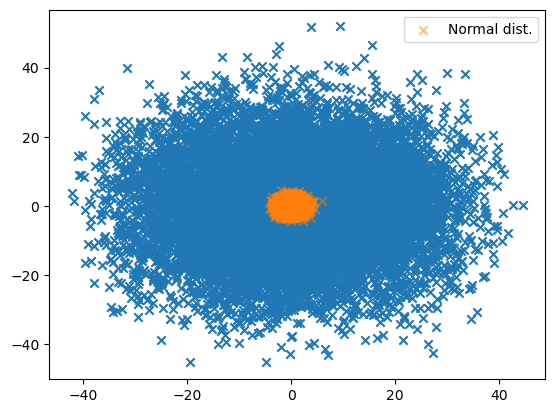

In [764]:
data = ds_samples.data.reshape(-1, 2)
plt.scatter(data[:,0],data[:,1],marker = 'x')

std = torch.ones(net.latent_size) #* np.array([np.std(data[:,0]) **2, np.std(data[:,1])**2]) 
mean = torch.zeros(net.latent_size)

samples = Normal(mean, std).rsample((10000,))
if net.latent_size > 2:
    samples = PCAs['samples'].fit_transform(samples)                                
plt.scatter(samples[:,0],samples[:,1], alpha = 0.5,marker = 'x', label = 'Normal dist.')

# plt.scatter(data[:,0],data[:,1],marker = 'x', label = 'train data samples all times')
plt.legend()

In [ ]:
# data = ds_samples.data.reshape(-1, 2)
# plt.scatter(data[:,0],data[:,1],marker = 'x')

# stds = torch.ones(2)*np.array([np.std(data[:,0]) **2, np.std(data[:,1])**2]) 
# mean = torch.zeros(2)

# truncated_dist = np.sqrt(((data - data.mean(axis = 0))**2).sum(-1)).max()
# samples = torch_normal_sampling(mean, stds, num_samples = 10000, truncated_dist = truncated_dist)

# plt.scatter(samples[:,0],samples[:,1], alpha = 0.5,marker = 'x', label = 'Normal dist.')

# # plt.scatter(data[:,0],data[:,1],marker = 'x', label = 'train data samples all times')
# plt.legend()

In [673]:

if params['condition_dependant_latent']:
    flow = 'off'
    for t in range(0,len(ds_train.time),100):


        if params['prior_flow'] is None:
            std = np.array([np.sqrt(ds_var_cond[t,i].values) for i in range(net.latent_size)])
            mean = np.array([ds_mu_cond[t,i].values for i in range(net.latent_size) ])
        else:
            std = np.ones(net.latent_size)
            mean = np.zeros(net.latent_size)

        samples = Normal(torch.from_numpy(mean), torch.from_numpy(std)).rsample( (1000,))

        if params['prior_flow'] is not None:
            flow = 'On'
            condition = torch.from_numpy(ds_emb[t].data[None,]).to(torch.float32).expand(1000,net.embedding_size )
            samples = net.flow.inverse((samples).to(torch.float32), condition = condition)[0].detach().numpy()

        if net.latent_size>2:
            samples = PCAs['samples'].fit_transform(samples)


# Separate the samples into x and y coordinates

        tweod_hist_plot(samples, title = f'conditional prior density at time {ds_train.time[t].values}')

In [640]:
def hist_sampling(hist, edges, latent_dim , num_samples = 200):
    
    hist_prob = hist / hist.sum()
    hist_flat = hist_prob.ravel()
    bin_indices = np.random.choice(len(hist_flat), p=hist_flat, size=num_samples)
    bin_coords = np.unravel_index(bin_indices, hist.shape)
    samples = np.zeros((num_samples, latent_dim)) 
    for dim in range(latent_dim):
        # Get the lower and upper edges for the current dimension's bins
        bin_lower_edges = edges[dim][bin_coords[dim]]
        bin_upper_edges = edges[dim][bin_coords[dim] + 1]

        # Uniformly sample within the bin's lower and upper edge for each dimension
        samples[:, dim] = np.random.uniform(bin_lower_edges, bin_upper_edges, size=num_samples)
    return samples

Text(0, 0.5, 'Y')

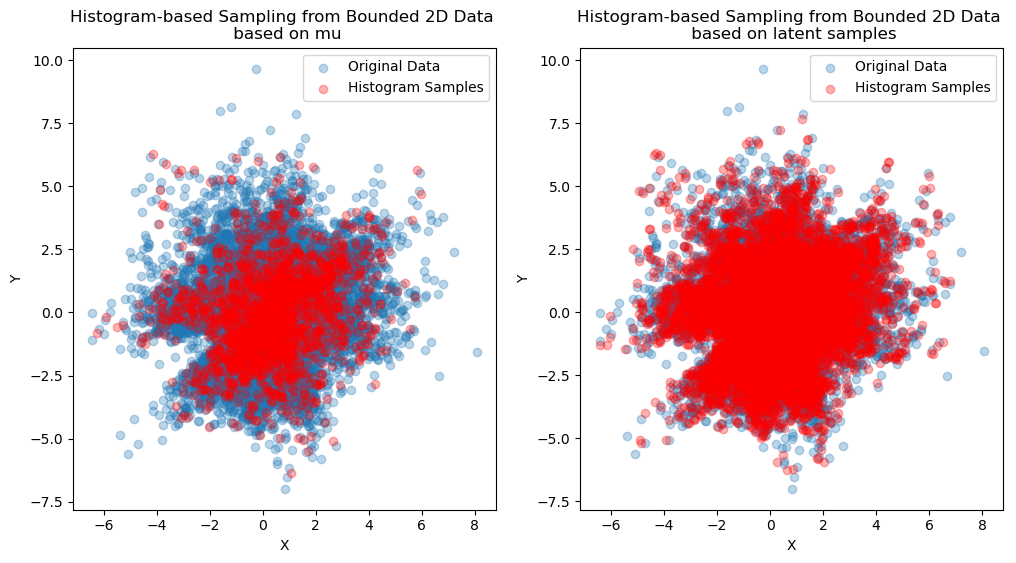

In [641]:
data = ds_mu.data.reshape(-1, 2) #[0,:,:]
hist, edges = np.histogramdd(data, bins=50)
samples = hist_sampling(hist, edges, 2, 2000)

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.scatter(data[:,0], data[:,1], alpha=0.3, label='Original Data')
plt.scatter(samples[:,0], samples[:,1], alpha=0.3, color='red', label='Histogram Samples')
plt.legend()
plt.title('Histogram-based Sampling from Bounded 2D Data \n based on mu')
plt.xlabel('X')
plt.ylabel('Y')



data = ds_samples.data.reshape(-1, 2) #[0,:,:]
hist, edges = np.histogramdd(data, bins=50)
samples = hist_sampling(hist, edges, 2, 10000)

plt.subplot(1,2,2)
plt.scatter(data[:,0], data[:,1], alpha=0.3, label='Original Data')
plt.scatter(samples[:,0], samples[:,1], alpha=0.3, color='red', label='Histogram Samples')
plt.legend()
plt.title('Histogram-based Sampling from Bounded 2D Data \n based on latent samples')
plt.xlabel('X')
plt.ylabel('Y')


In [100]:
data = ds_mu # ds_samples


plt.figure(figsize = (20,50))
for e in range(1,41):
    plt.subplot(10,4,e)
    x = data[:,e,0].values
    y = data[:,e,1].values
    z = data.year.values[:] + (data.lead_time.values[:] - 0.5) /12
    scatter = plt.scatter(x,y ,c=z, cmap='viridis_r', marker = 'x', s = 5)
    plt.colorbar(scatter)
    plt.title(f'ensemble member {e}')

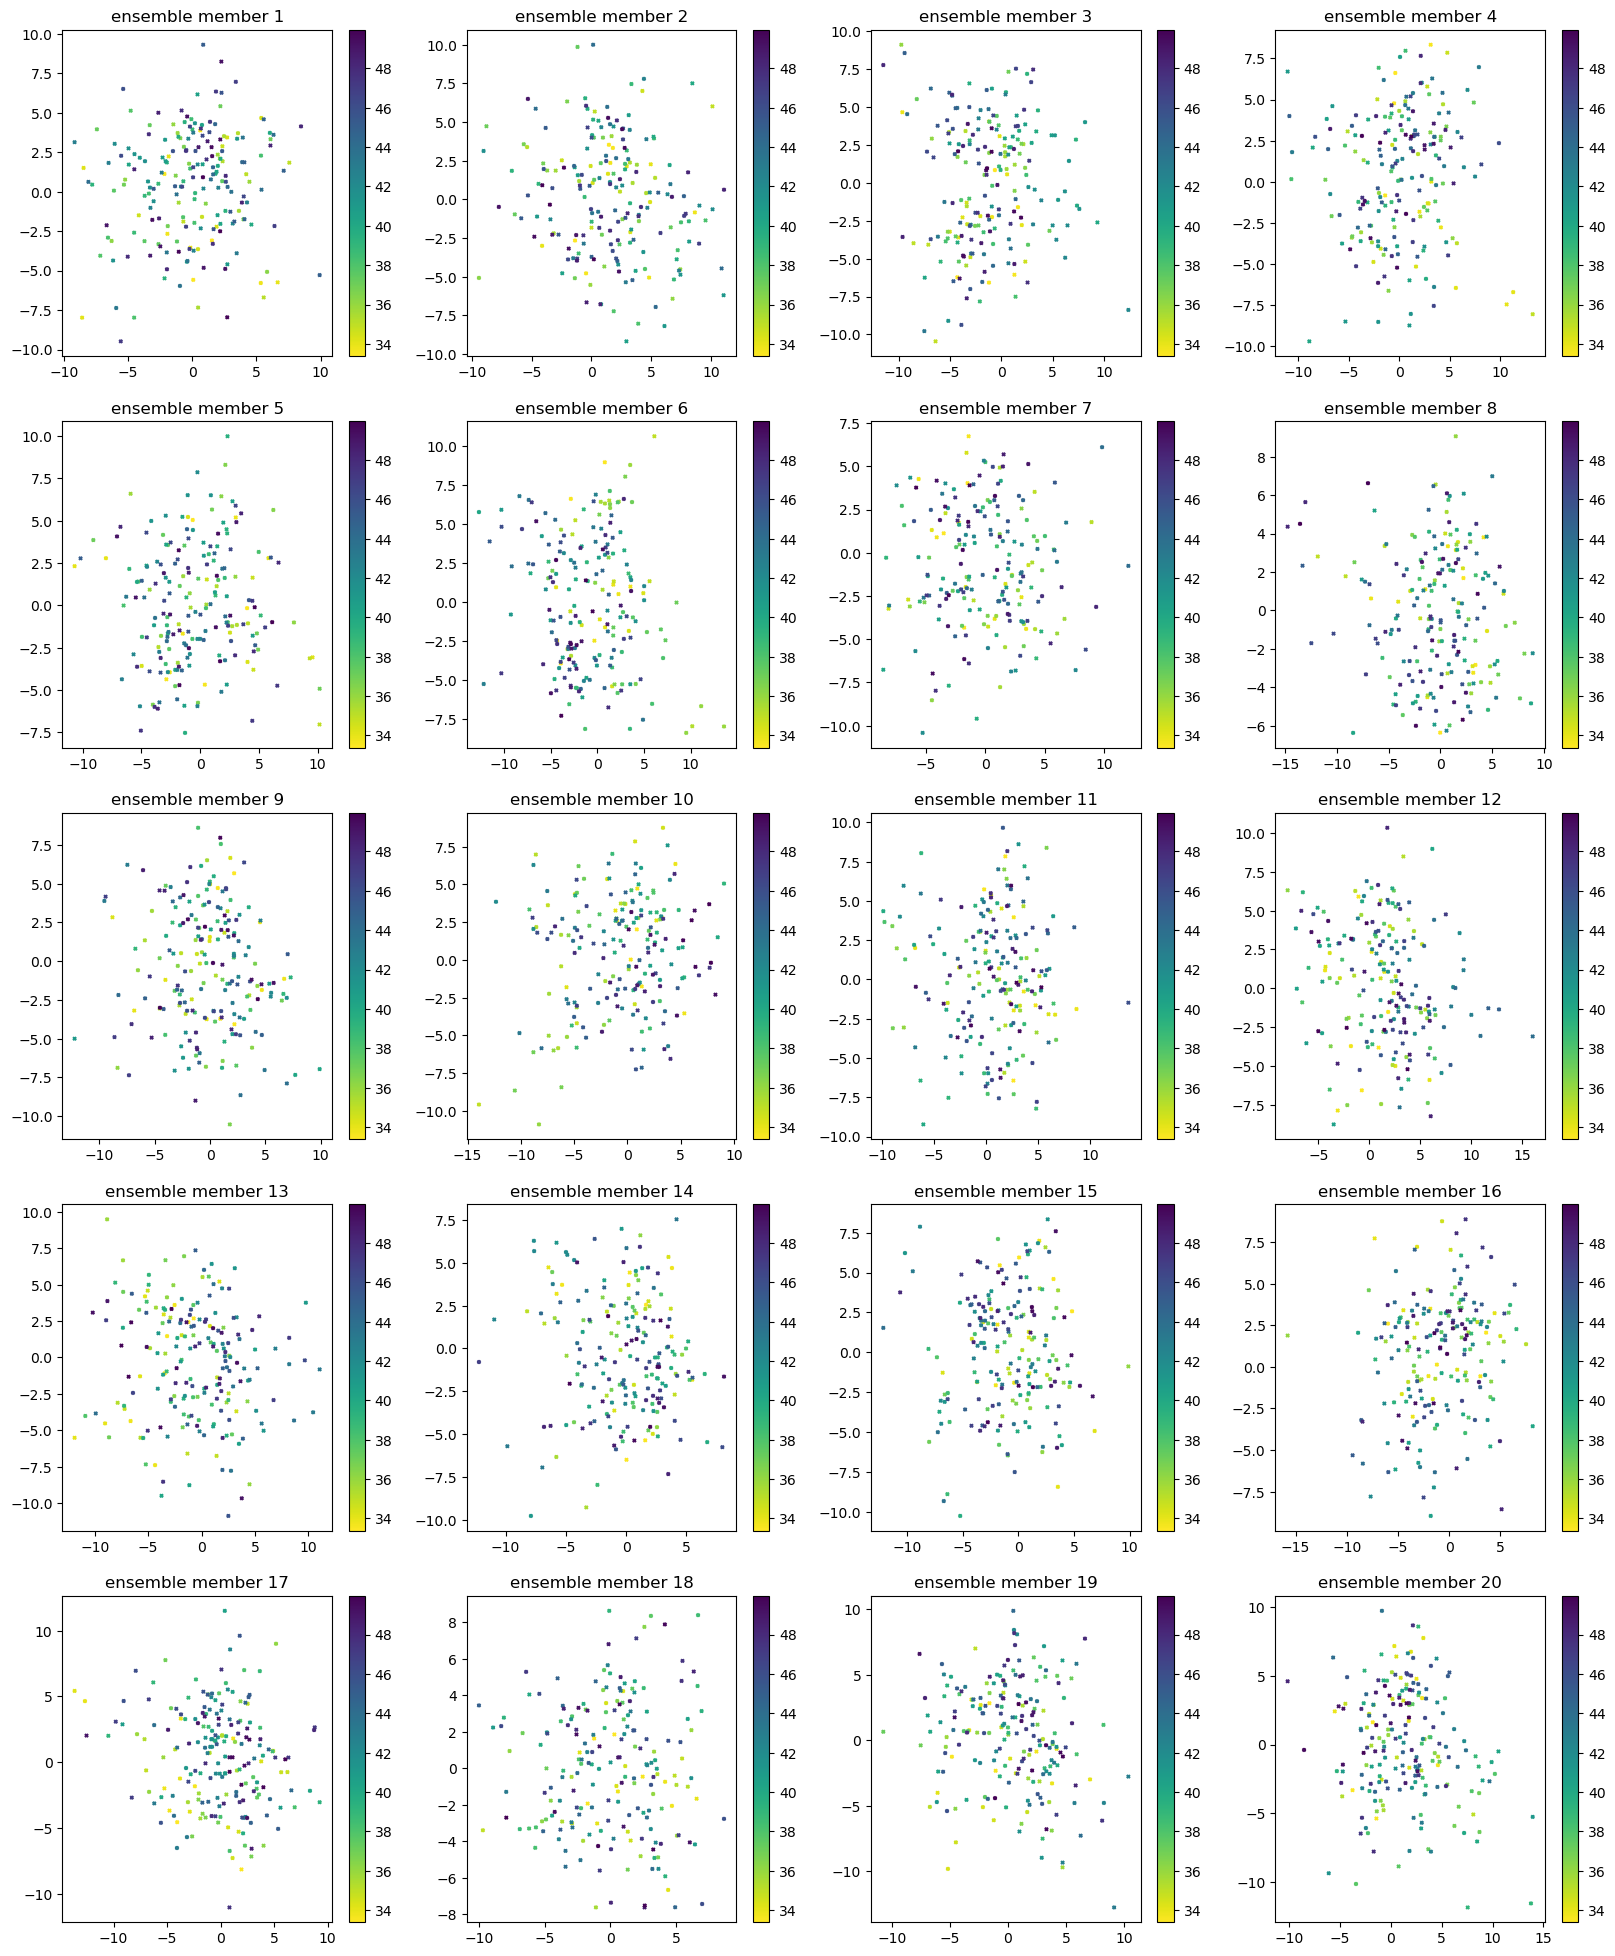

In [177]:
data = ds_mu # ds_samples

plt.figure(figsize = (20,50))
for e in range(1,21):
    plt.subplot(10,4,e)
    x = data[-200:,e,0].values
    y = data[-200:,e,1].values
    z = data.year.values[-200:] + (data.lead_time.values[-200:] - 0.5) /12
    scatter = plt.scatter(x,y ,c=z, cmap='viridis_r', marker = 'x', s = 5)
    plt.colorbar(scatter)
    plt.title(f'ensemble member {e}')

In [91]:


def save_animation(e, vmin = -3, vmax = 3):

    # Example data
    x = ds_mu[:,e,0].values
    y = ds_mu[:,e,1].values
    values = ds_mu.year.values[:] + (ds_mu.lead_time.values[:] - 0.5) /12

    # Initialize the plot
    fig, ax = plt.subplots()
    scat = ax.scatter([], [], c=[], cmap='viridis_r', s=5, vmin=values.min(), vmax=values.max())
    ax.set_xlim(vmin , vmax )
    ax.set_ylim(vmin , vmax )
    ax.set_title(f'ensemble {e + 1}')
    cbar = plt.colorbar(scat, ax=ax)
    cbar.set_label('time')
    # cbar.set_clim(values.min(), values.max())
    # Update function for animation

    def update(frame):
        # Add one more point each frame
        current_x = x[:frame+1]
        current_y = y[:frame+1]
        current_values = values[:frame+1]
        
        # Update the scatter plot data
        scat.set_offsets(np.c_[current_x, current_y])
        scat.set_array(current_values)

        ax.set_title(f'ensemble {e + 1} \n {ds_mu.year.values[frame] * 100 + ds_mu.lead_time.values[frame] }')
        return scat,
    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(x), interval=100, blit=True)

    Path(nn_dir + '/gifs').mkdir(parents=True, exist_ok=True)
    ani.save( nn_dir + f'/gifs/scatter_animation_ensemble_{e+1}.gif', writer='imagemagick', dpi=100)
    plt.close()
  


In [92]:
for e in range(5):
    save_animation(e, -4,4)


MovieWriter imagemagick unavailable; using Pillow instead.


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


In [ ]:
data = ds_mu #ds_samples #ds_mu

plt.figure(figsize = (20,100))
for ind, t in enumerate(range(0,len(ds_train.time),12)):
    plt.subplot(20,4,ind + 1)
    for m in range(12):
        x = data[t + m,:,0].values
        y = data[t + m,:,1].values
        z = data[t + m,:,0].ensembles.values
        scatter = plt.scatter(x,y ,c=z, cmap='viridis_r', s = 5)


    plt.colorbar(scatter)
    plt.title(f'year {ds_train.year.values[t]}')

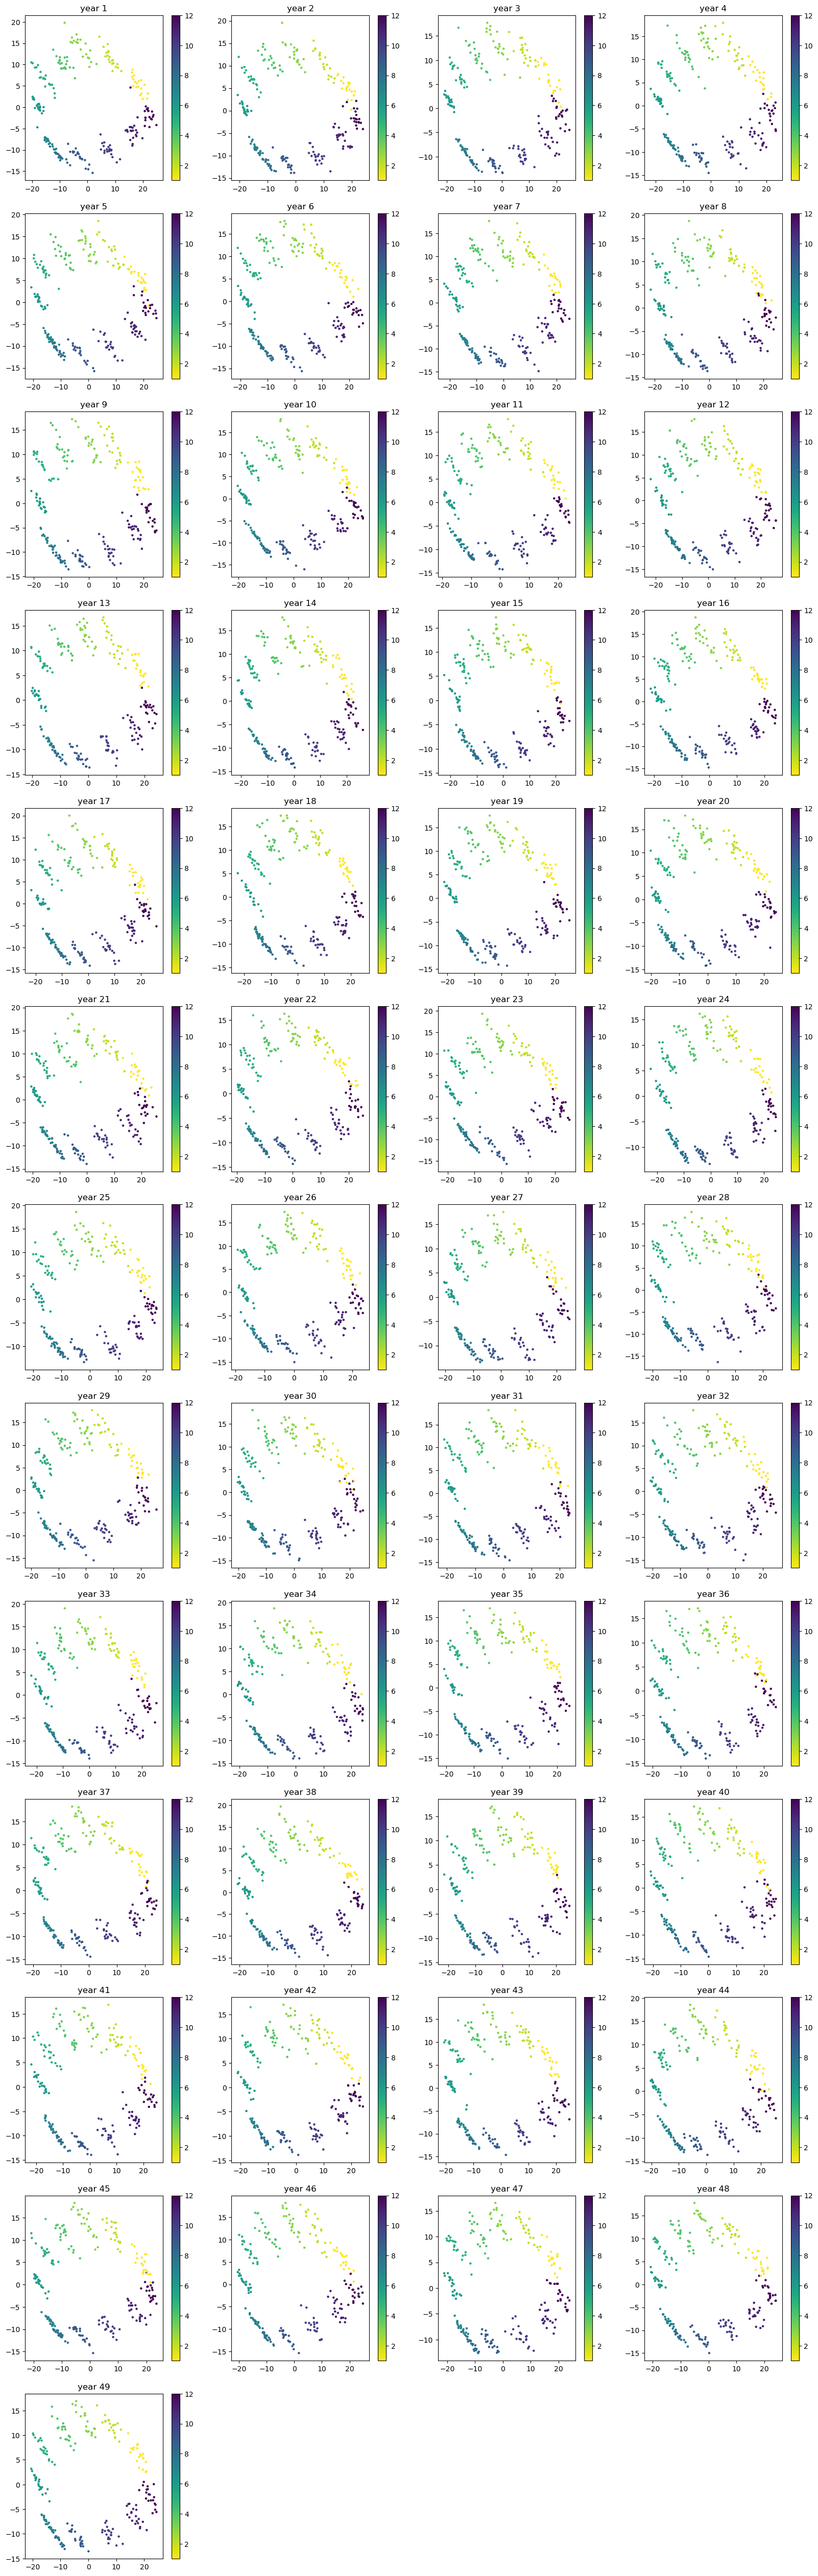

In [596]:
data  = ds_mu #ds_samples

plt.figure(figsize = (20,100))
for ind, t in enumerate(range(0,len(ds_train.time),12)):
    plt.subplot(20,4,ind + 1)
    for e in range(20):
        x = data[t :t +12,e,0].values
        y = data[t :t +12,e,1].values
        z = data[t :t +12,e,0].lead_time.values
        scatter = plt.scatter(x,y ,c=z, cmap='viridis_r', s = 5)


    plt.colorbar(scatter)
    plt.title(f'year {ds_train.year.values[t]}')

In [ ]:

for m in range(12):
    plt.figure(figsize = (20,100))
    for ind, t in enumerate(range(0,len(ds_train.time),12)):
        plt.subplot(20,4,ind + 1)
        
        x = ds_mu[t + m,:,0].values
        y = ds_mu[t + m,:,1].values
        z = ds_mu[t + m,:,0].ensembles.values
        scatter = plt.scatter(x,y ,c=z, cmap='viridis_r', s = 5)

        plt.colorbar(scatter)
        plt.title(f'year {ds_train.year.values[t]} - month {m}')

## Hist vs time (needs editing)

In [75]:
########
ds_full = xr.open_mfdataset(data_dir_forecast).tas
#############

ds_train_full = ds_full.stack(time = ('year','lead_time')).stack(ref = ('lat','lon')).transpose('time','ensembles',...,'ref').expand_dims('channels', axis = -2).load()


# ds_train_full = ds_pipeline.transform(ds_train_full)
if params['remove_ensemble_mean']:
    ds_train_full = ds_train_full - ds_train_full.mean('ensembles')

if params['version'] == 1:
    standardizer = Standardizer()
    standardizer.fit(ds_train_full[:n_train,...])
    ds_train_full = standardizer.transform(ds_train_full)

if conditional_embedding:
    ds_train_conds = ds_em.sel(year = ds_full.year).stack(time = ('year','lead_time')).stack(ref = ('lat','lon')).transpose('time',...,'ref')


if params['time_features'] is not None:
    time_features_list = np.array([params['time_features']]).flatten()
    feature_indices = {'year': 0, 'lead_time': 1, 'month_sin': 2, 'month_cos': 3, 'sin_t' : 4, 'cos_t' : 5}
    y = (ds_train_full.year.to_numpy() + np.floor(ds_train_full.lead_time.to_numpy()/12)) / year_max
    t =  np.arange(len(ds_train_full.year))
    lt = ds_train_full.lead_time.to_numpy() / np.max(ds_train_full.lead_time.to_numpy())
    tsin = np.sin(t)
    tcos = np.cos(t)
    msin = np.sin(2 * np.pi * ds_train_full.lead_time/12.0)
    mcos = np.cos(2 * np.pi * ds_train_full.lead_time/12.0)
    time_features = np.stack([y, lt, msin, mcos, tsin, tcos], axis=1)
    time_features = time_features[..., [feature_indices[k] for k in time_features_list]]

ds_samples_full = xr.concat([xr.full_like(ds_train_full[...,-1].squeeze().drop(['ref','lat','lon']), np.NAN) for _ in range(latent_dim)],dim = 'mu').transpose('time','ensembles',...,'mu').rename('latent')
ds_mu_full = ds_samples_full.copy()

if all([params['condition_dependant_latent'], params['prior_flow'] is None]):
    ds_cond_mu_full = ds_samples_full.isel(ensembles = 0).copy() 
    ds_cond_var_full = ds_samples_full.isel(ensembles = 0).copy()
if any([params['prior_flow'] is not None, params['condemb_to_decoder']]):
    ds_emb_full = ds_samples_full.isel(ensembles = 0).copy()

for t in range(len(ds_train_full.time)):
    x_in = torch.from_numpy(ds_train_full[t].data).to(torch.float32)
    if conditional_embedding:
        cond = torch.from_numpy(ds_train_conds.isel(time = t).data).to(torch.float32)
        if params['condition_dependant_latent']:
            if all([params['prior_flow'] is None,params['condemb_to_decoder']])  :
                    ds_emb_full[t,:] = net.condition_mu(net.embedding(cond.flatten(start_dim=1))).detach().numpy().squeeze()
            elif params['prior_flow'] is not None:
                    ds_emb_full[t,:]= (net.embedding(cond.flatten(start_dim=1))).detach().numpy().squeeze()
        elif params['condemb_to_decoder']:
            ds_emb_full[t,:] = net.embedding(cond.flatten(start_dim=1)).detach().numpy().squeeze()   
        cond = cond.unsqueeze(0).expand_as(x_in)
    else:
        cond = None

    if all([time_features is not None, params['append_mode'] in [1,3]]):
        tf = torch.from_numpy(time_features[t][None,]).to(torch.float32)
        x_in = (x_in, tf.expand(x_in.shape[0], add_feature_dim))
    
    with torch.no_grad():
        mu, log_var = net(x_in, condition = cond, sample_size = 1)[1:3]
        ds_samples_full[t,:,:] = net.sample(mu, log_var, 1)[0]
        ds_mu_full[t,:,:] = mu

        if params['condition_dependant_latent']:
            if params['prior_flow'] is None:
                ds_cond_mu_full[t,:] = net.condition_mu(net.embedding(torch.from_numpy(ds_train_conds.isel(time = t).data).to(torch.float32))).squeeze()
                ds_cond_var_full[t,:] = torch.exp(net.condition_log_var(net.embedding(torch.from_numpy(ds_train_conds.isel(time = t).data).to(torch.float32))).squeeze()) + 1e-4

In [ ]:
for t in range(0,60,10):

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(121, projection='3d')

    data = ds_mu_full[t,:,:].data

    hist, xedges, yedges = np.histogram2d(data[:,0], data[:,1], bins=50)
    hist_prob = hist / hist.sum()
    # Create the meshgrid for the bin edges
    xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
    # Calulate the bin centers (for plotting the surface at the middle of each bin)
    xpos_centers = (xedges[:-1] + xedges[1:]) / 2
    ypos_centers = (yedges[:-1] + yedges[1:]) / 2
    # Create a meshgrid of the bin centers
    xpos_centered, ypos_centered = np.meshgrid(xpos_centers, ypos_centers)
    # Create the figure and a 3D axis
    # Plot a surface plot
    ax.plot_surface(xpos_centered, ypos_centered, hist.T, cmap='viridis')
    ax.set_title(f'time = {ds_mu_full[t,:,:].time.values} ds full mu')


    ax = fig.add_subplot(122, projection='3d')

    data = ds_samples_full[t,:,:].data

    hist, xedges, yedges = np.histogram2d(data[:,0], data[:,1], bins=50)
    hist_prob = hist / hist.sum()
    # Create the meshgrid for the bin edges
    xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
    # Calulate the bin centers (for plotting the surface at the middle of each bin)
    xpos_centers = (xedges[:-1] + xedges[1:]) / 2
    ypos_centers = (yedges[:-1] + yedges[1:]) / 2
    # Create a meshgrid of the bin centers
    xpos_centered, ypos_centered = np.meshgrid(xpos_centers, ypos_centers)
    # Create the figure and a 3D axis
    # Plot a surface plot
    # Plot a surface plot
    ax.plot_surface(xpos_centered, ypos_centered, hist.T, cmap='viridis')
    ax.set_title(f'time = {ds_samples_full[t,:,:].time.values} ds full samples')


    




In [77]:
if params['condition_dependant_latent']:
    flow = 'off'
    for t in range(0,24,4):
        if params['prior_flow'] is None:
            cov = [[ds_cond_var_full[t,0].values, 0], 
                [0, ds_cond_var_full[t,1].values]]
            mean = [ds_cond_mu_full[t,0].values, ds_cond_mu_full[t,1].values]
            # cov = [[np.var(ds_mu[t,:,0].values), 0], 
            #     [0, np.var(ds_mu[t,:,1].values)]]
            # mean = [np.mean(ds_mu[t,:,0].values), np.mean(ds_mu[t,:,1].values)]
        else:
            cov = torch.eye(2)
            mean = torch.zeros(2)

        samples = np.random.multivariate_normal(mean, cov, size=1000)

        if params['prior_flow'] is not None:
            flow = 'On'
            condition = torch.from_numpy(ds_emb_full[t].data[None,]).to(torch.float32).expand(1000,net.embedding_size )
            samples = net.flow.inverse(torch.from_numpy(samples).to(torch.float32), condition = condition)[0].detach().numpy()

# Separate the samples into x and y coordinates

        tweod_hist_plot(samples, title = f'conditional prior density at time {ds_train.time[-24:][t].values}')

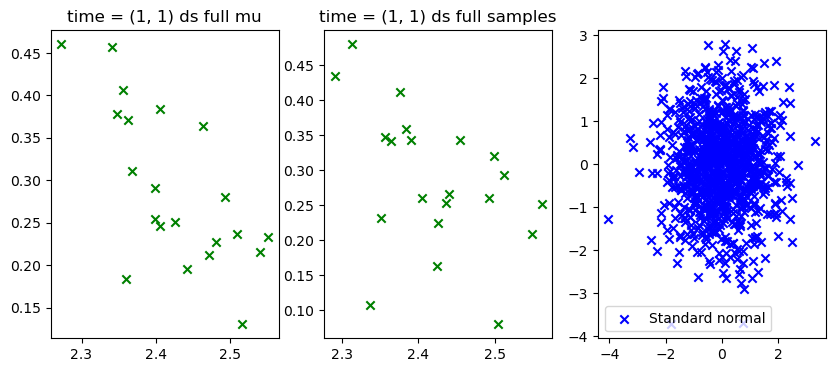

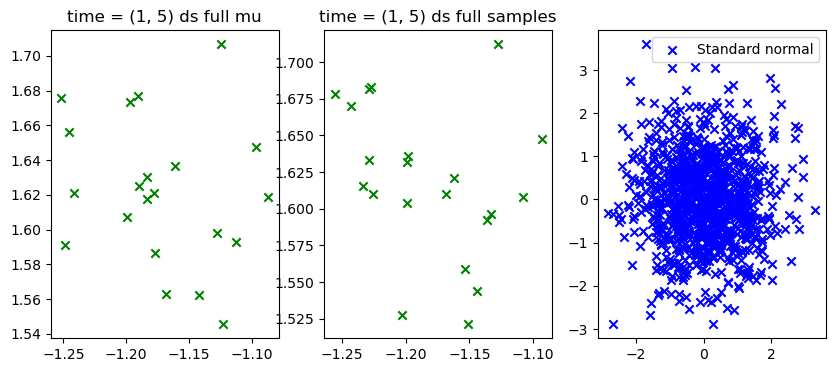

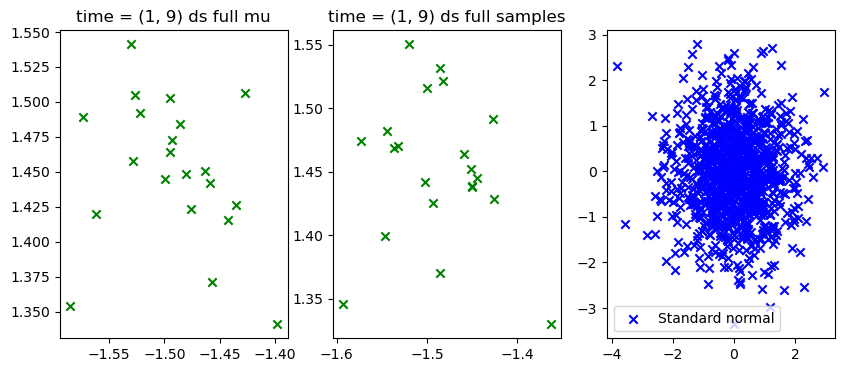

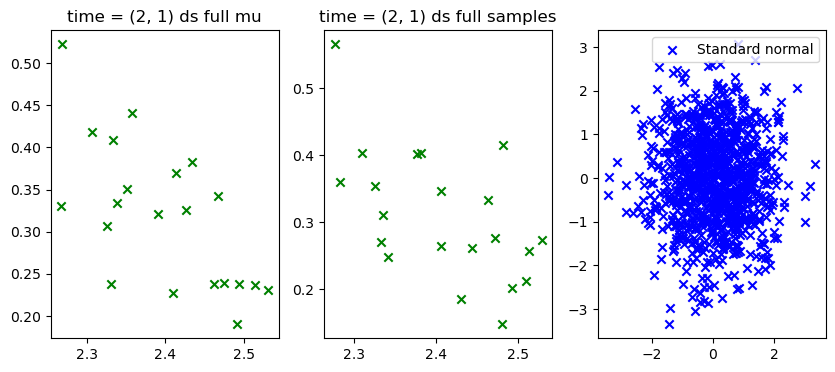

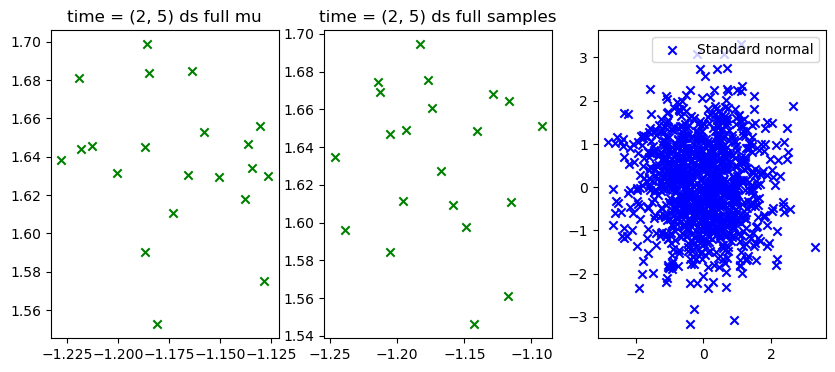

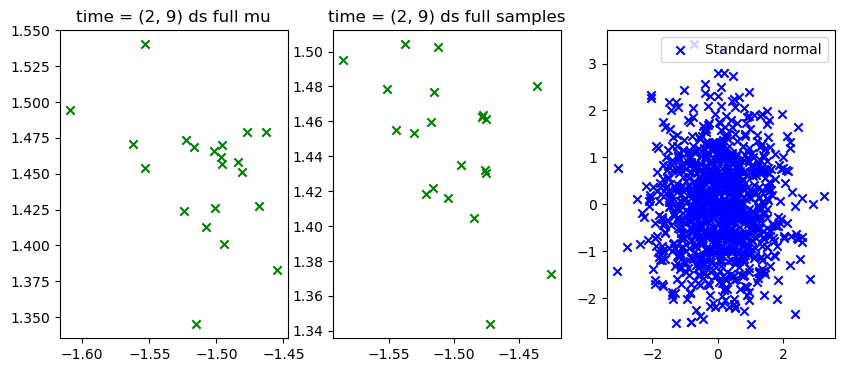

In [78]:

for t in range(0,24,4):

    fig = plt.figure(figsize=(10, 4))
    data = ds_mu_full[t,:,:].data

    plt.subplot(1,3,1)
    plt.scatter(data[:,0], data[:,1], marker = 'x', color='g')
    plt.title(f'time = {ds_mu_full[t,:,:].time.values} ds full mu')

    plt.subplot(1,3,2)
    data = ds_samples_full[t,:,:].data
    plt.scatter(data[:,0], data[:,1], marker = 'x',  color='g')

    plt.title(f'time = {ds_mu_full[t,:,:].time.values} ds full samples')


    flow = 'off'
    if params['condition_dependant_latent']:
        if params['prior_flow'] is None:
            cov = [[ds_cond_var_full[t,0].values, 0], 
                [0, ds_cond_var_full[t,1].values]]
            mean = [ds_cond_mu_full[t,0].values, ds_cond_mu_full[t,1].values]
    else:
        cov = torch.eye(2)
        mean = torch.zeros(2)

    samples = np.random.multivariate_normal(mean, cov, size=1000)

    if params['prior_flow'] is not None:
        flow = 'On'
        condition = torch.from_numpy(ds_emb_full[t].data[None,]).to(torch.float32).expand(1000,net.embedding_size )
        samples = net.flow.inverse(torch.from_numpy(samples).to(torch.float32), condition = condition)[0].detach().numpy()


    plt.subplot(1,3,3)
    if params['condition_dependant_latent']:
        plt.scatter(samples[:,0], samples[:,1], marker = 'x',   color='b', label = f'conditional prior samples flow {flow}', facecolor = None)
    else:
        plt.scatter(samples[:,0], samples[:,1], marker = 'x',   color='b', label = f'Standard normal', facecolor = None)
    plt.legend()

    




# piControl

### generate data

In [590]:
tas = xr.open_mfdataset('/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/data/tas/piControl/*.nc').ts -273.15
tas = xr.concat([tas[t:t+12].rename({'time' : 'lead_time'}).assign_coords(lead_time = np.arange(1,13)) for t in range(0,12612,12)], dim = 'year').assign_coords(year = np.arange(1,1052))
tas_ens = xr.concat([tas[i:i+50].assign_coords(year = tas[:50].year.values) for i in range(0,len(tas.year) -1 ,50)],dim = 'ensembles').transpose('year','lead_time','ensembles',...)
tas_ens = tas_ens.assign_coords(ensembles = np.arange(1,len(tas_ens.ensembles)+1))

del tas

In [715]:
tas_anom = tas_ens - tas_ens.mean(['year'])
tas_nino = tas_anom.where((tas_anom.lat >= -5) & (tas_anom.lat<= 5), drop = True)
tas_nino = tas_nino.where((tas_nino.lon >= 190) & (tas_nino.lon<= 240), drop = True).mean(['lat','lon'])
lanithreshold = [  np.quantile(tas_nino.sel(lead_time = m).values,0.25) for m in np.arange(1,13)]
ninothreshold = [  np.quantile(tas_nino.sel(lead_time = m).values,0.75) for m in np.arange(1,13)]


In [716]:
import random
ens_size = 6
num_samples= 100
ensem_ids = np.arange(0,len(tas_ens.ensembles))
ls = []
for _ in range(num_samples):
    random.shuffle(ensem_ids)
    ls.append(tas_ens.isel(ensembles = ensem_ids[:ens_size]))


tas_sample = xr.concat(ls, dim = 'samples')
tas_sample = tas_sample - tas_sample.mean(['year'])

In [717]:

tas_nino_sample = tas_sample.where((tas_sample.lat >= -5) & (tas_sample.lat<= 5), drop = True)
tas_nino_sample = tas_nino_sample.where((tas_nino_sample.lon >= 190) & (tas_nino_sample.lon<= 240), drop = True).mean(['lat','lon'])

# lanithreshold_sample.append([np.quantile(tas_nino_sample.sel(month = m).values,0.25) for m in np.arange(1,13)])
# ninothreshold_sample_list.append([np.quantile(tas_nino_sample.sel(month = m).values,0.75) for m in np.arange(1,13)])



Text(0, 0.5, 'Nino 3.4 index [std]')

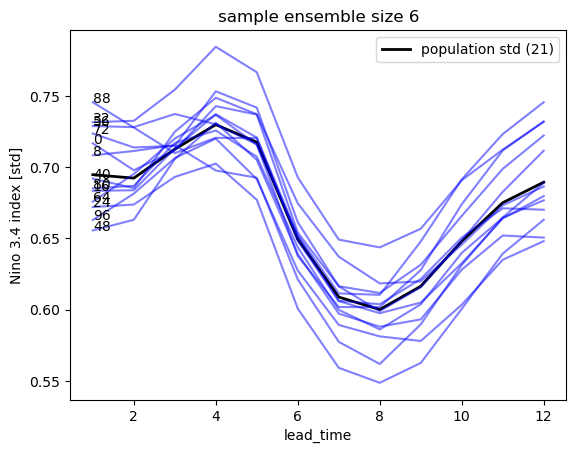

In [605]:
tas_nino.std(['year','ensembles']).plot(label = f'population std ({len(tas_nino.ensembles)})', color = 'k', linewidth = 2)
for i in range(0,num_samples,8):
    tas_nino_sample[i].std(['year','ensembles']).plot(alpha = 0.5, color = 'b')
    plt.text(1, tas_nino_sample[i].std(['year','ensembles']).sel(lead_time = 1).values, f'{i}')
plt.legend()
plt.title(f'sample ensemble size {ens_size}')
plt.ylabel('Nino 3.4 index [std]')

Text(0, 0.5, 'Nino 3.4 index [std]')

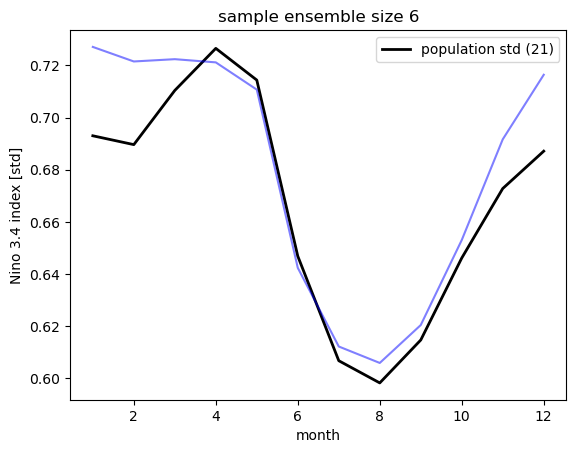

In [537]:
i = 24
tas_nino.std(['year','ensembles']).plot(label = f'population std ({len(tas_nino.s)})', color = 'k', linewidth = 2)
tas_nino_sample[i].std(['year','ensembles']).plot(alpha = 0.5, color = 'b')
plt.legend()
plt.title(f'sample ensembles size {ens_size}')
plt.ylabel('Nino 3.4 index [std]')

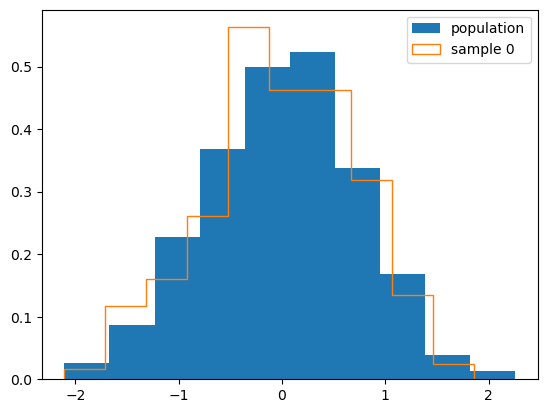

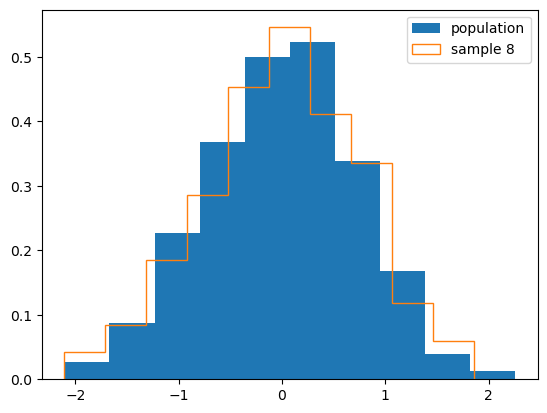

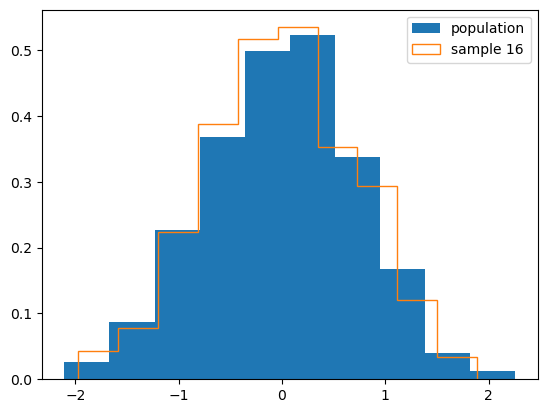

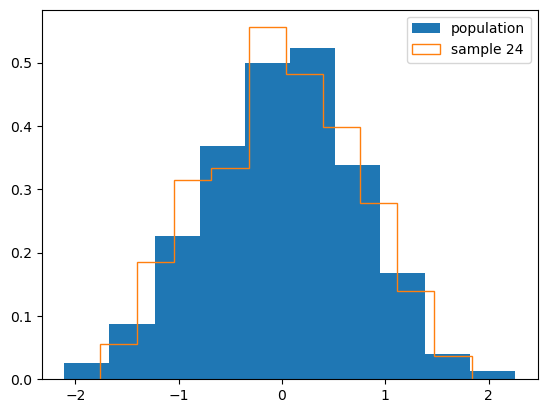

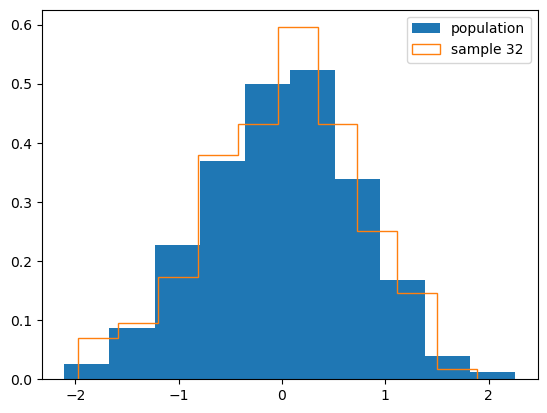

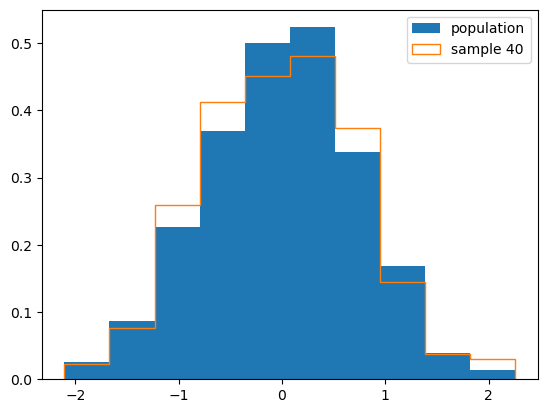

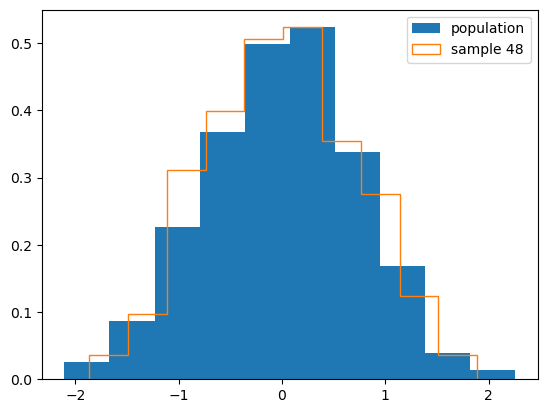

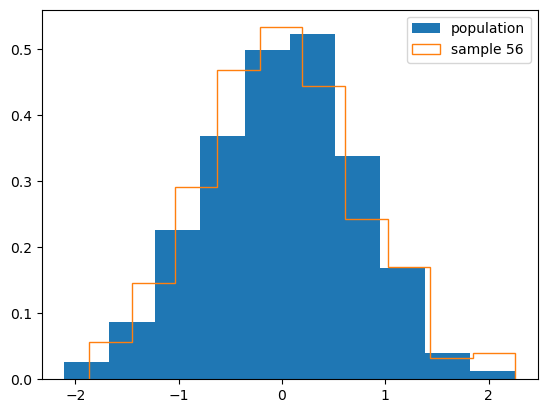

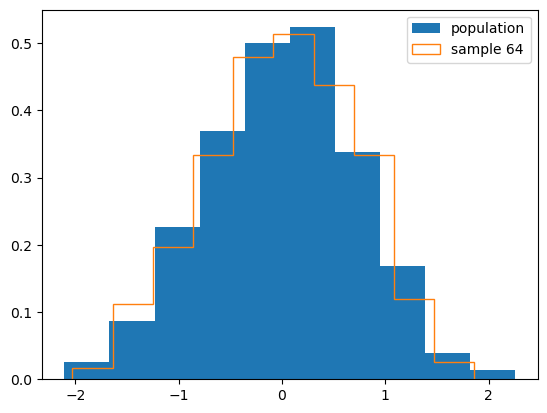

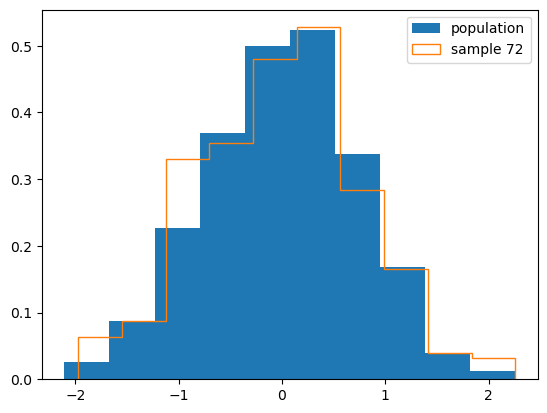

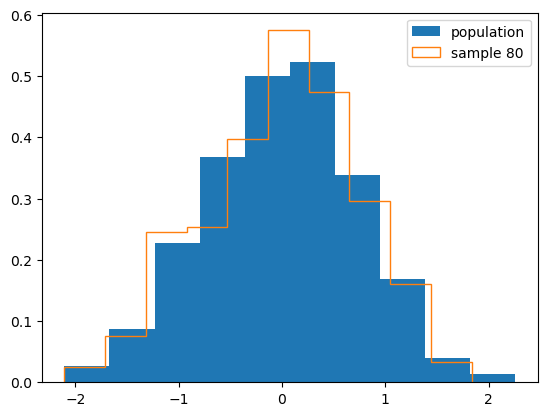

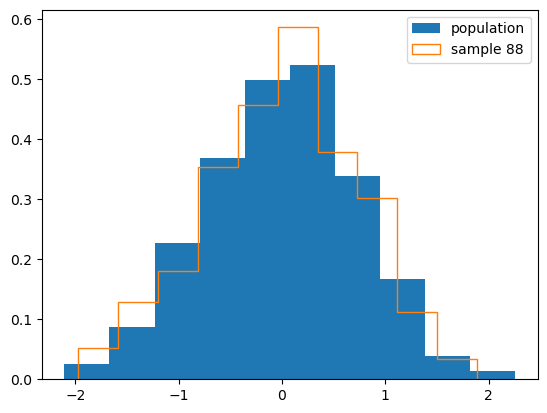

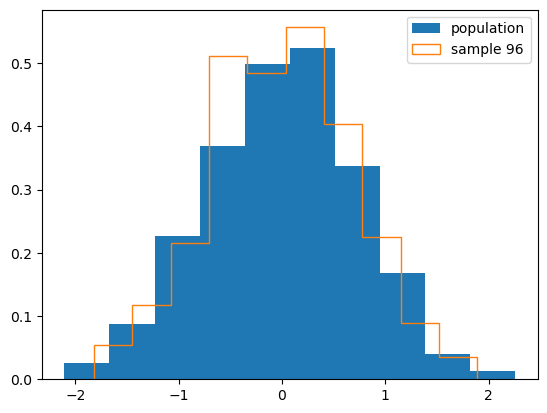

In [536]:
for i in range(0,100,8):
    plt.figure()
    plt.hist(tas_nino.sel(month = 4).values.flatten(), density = True, histtype='stepfilled', bins = 10, label = 'population')
    plt.hist(tas_nino_sample[i].sel(month = 4).values.flatten(), density = True, histtype='step', bins = 10, label = f'sample {i}')
    plt.legend()
    # plt.vlines( lanithreshold[3],0,0.6, color = 'r', label = 'thresholds population')
    # plt.vlines( ninothreshold[3],0,0.6,  color = 'r')

# plt.vlines( lanithreshold_sample[3],0,0.6, color = 'r',linestyle = 'dashed', label = 'thresholds sample')
# plt.vlines( ninothreshold_sample[3],0,0.6,  color = 'r',linestyle = 'dashed')



first choice 5 members

In [525]:
training_ens_members = tas_nino_sample[88].dropna('ensemble').ensemble.values
print(training_ens_members)

[ 4  7 11 12 20]


Text(0, 0.5, 'Nino 3.4 index [std]')

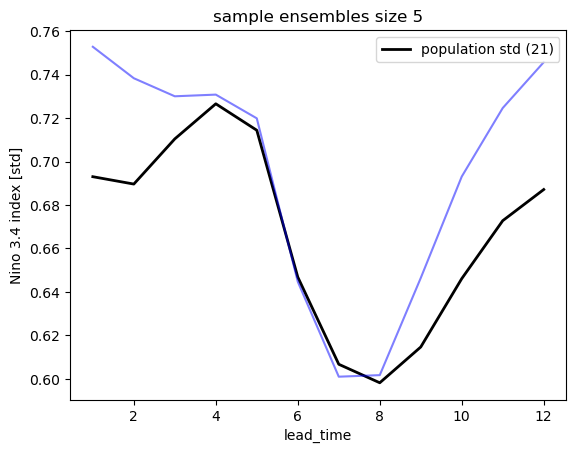

In [726]:
tas_sample = tas_ens.sel(ensembles = [4 , 7 ,11, 12, 20])
tas_sample = tas_sample - tas_sample.mean('year')
tas_nino_sample = tas_sample.where((tas_sample.lat >= -5) & (tas_sample.lat<= 5), drop = True)
tas_nino_sample = tas_nino_sample.where((tas_nino_sample.lon >= 190) & (tas_nino_sample.lon<= 240), drop = True).mean(['lat','lon'])

tas_nino.std(['year','ensembles']).plot(label = f'population std ({len(tas_nino.ensembles)})', color = 'k', linewidth = 2)
tas_nino_sample.std(['year','ensembles']).plot(alpha = 0.5, color = 'b')
plt.legend()
plt.title(f'sample ensembles size {len(tas_sample.ensembles)}')
plt.ylabel('Nino 3.4 index [std]')

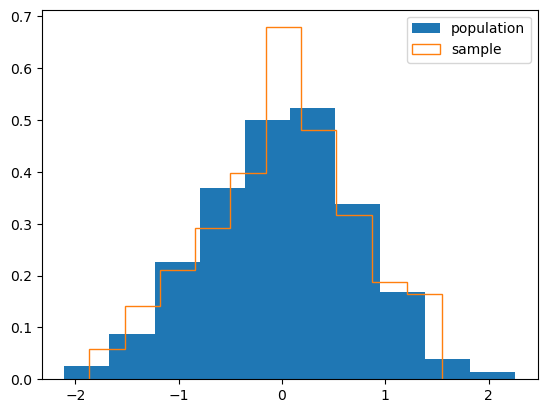

In [724]:
plt.figure()
plt.hist(tas_nino.sel(lead_time = 4).values.flatten(), density = True, histtype='stepfilled', bins = 10, label = 'population')
plt.hist(tas_nino_sample.sel(lead_time = 4).values.flatten(), density = True, histtype='step', bins = 10, label = f'sample')
plt.legend()

### NN test

In [765]:
ds_full = xr.open_dataset("/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/data/tas/piControl/tas_piControl_LE_0101-5112.nc")['tas'].transpose('year','lead_time','ensembles',...)
ds_in = ds_full.sel(ensembles = [ 4 , 7, 11, 12 ,20])
nn_dir = '/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/output/tas/SOM-FFN/results/Autoencoder/run_set_1_picontrol/N1_v2_B0.01_L0_archNone_batch10_e100_lr_scheduler_BVAE_50-100_NnRandDecodInit_MSESUM_picontrol_TSE5_LS500/tests'
nn_adjusted = xr.open_mfdataset(str(Path(nn_dir, "*.nc")), combine='nested', concat_dim='year').load()['nn_adjusted']#[...,10:-10,:]


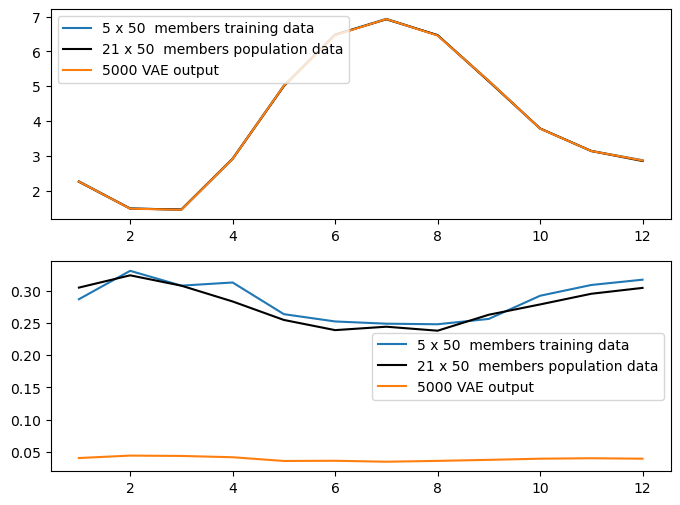

In [766]:
nn_year = 50

dstp = ds_in.mean(['lat','lon'])
dstp2 = ds_full.mean(['lat','lon'])
dstp3 = nn_adjusted.sel(year = slice(nn_year,nn_year)).mean(['lat','lon'])

plt.figure(figsize = (8,6))
plt.subplot(2,1,1)
plt.plot(np.arange(1,13), dstp.mean(['year','ensembles']), label = f'{len(ds_in.ensembles)} x {len(ds_in.year)}  members training data')
plt.plot(np.arange(1,13), dstp2.mean(['year','ensembles']), label = f'{len(ds_full.ensembles)} x {len(ds_full.year)}  members population data', color = 'k')
plt.plot(np.arange(1,13), dstp3.mean(['year','ensembles']).squeeze(), label = f'{len(nn_adjusted.ensembles)} VAE output')
plt.legend()

plt.subplot(2,1,2)
plt.plot(np.arange(1,13), dstp.std(['year','ensembles']), label = f'{len(ds_in.ensembles)} x {len(ds_in.year)}  members training data')
plt.plot(np.arange(1,13), dstp2.std(['year','ensembles']), label = f'{len(ds_full.ensembles)} x {len(ds_full.year)}  members population data', color = 'k')
plt.plot(np.arange(1,13), dstp3.std(['year','ensembles']).squeeze(), label = f'{len(nn_adjusted.ensembles)} VAE output')
plt.legend()


In [767]:
plt.figure(figsize = (10,13))
nn_year = int(input('nn_year?'))
lead_time = int(input('lead_time?'))

dstp = ds_in.sel(lead_time = lead_time)
plt.subplot(3,2,1)
dstp.mean(['ensembles','year']).plot()
plt.title(f'month {lead_time} \n Train data {len(dstp.ensembles)} x {len(dstp.year)} members mean')
# plt.xlabel('')

plt.subplot(3,2,2)
ref =  ds_full.sel( lead_time = lead_time).std(['ensembles','year'])
dstp.std(['ensembles','year']).plot()
corr = corr_map(ref, dstp.std(['ensembles','year'])).values
plt.title(f'Train data {len(dstp.ensembles)} x {len(dstp.year)}  members grid wise std ({np.round(corr,2)})')
plt.xlabel('')
plt.ylabel('')



dstp = ds_full.sel(lead_time = lead_time)
plt.subplot(3,2,3)
dstp.mean(['ensembles','year']).plot()
plt.title(f'ds_full {len(dstp.ensembles)} x {len(dstp.year)} members mean')
plt.xlabel('')
plt.subplot(3,2,4)
dstp.std(['ensembles','year']).plot()
corr = corr_map(ref, dstp.std(['ensembles','year'])).values
plt.title(f'ds_full {len(dstp.ensembles)} x {len(dstp.year)} members grid wise std ({np.round(corr,2)})')
plt.xlabel('')
plt.ylabel('')



dstp = nn_adjusted.sel(year = slice(nn_year,nn_year), lead_time = lead_time).squeeze()
plt.subplot(3,2,5)

dstp.mean('ensembles').plot()
plt.title(f'nn {len(dstp.ensembles)} members mean')
plt.subplot(3,2,6)
dstp.std('ensembles').plot()
corr = corr_map(ref, dstp.std(['ensembles'])).values
plt.title(f'nn {len(dstp.ensembles)} members grid wise std ({np.round(corr,2)})')
plt.ylabel('')


ValueError: invalid literal for int() with base 10: ''

<Figure size 1000x1300 with 0 Axes>

In [769]:
nn_adjusted_anoms = nn_adjusted - nn_adjusted.mean(['ensembles'])
nn_nino_sample = nn_adjusted_anoms.where((nn_adjusted_anoms.lat >= -5) & (nn_adjusted_anoms.lat<= 5), drop = True)
nn_nino_sample = nn_nino_sample.where((nn_nino_sample.lon >= 190) & (nn_nino_sample.lon<= 240), drop = True).mean(['lat','lon'])

ds_in_anoms = ds_in - ds_in.mean(['year'])
ds_in_nino = ds_in_anoms.where((ds_in_anoms.lat >= -5) & (ds_in_anoms.lat<= 5), drop = True)
ds_in_nino = ds_in_nino.where((ds_in_nino.lon >= 190) & (ds_in_nino.lon<= 240), drop = True).mean(['lat','lon'])

ds_full_anoms = ds_full - ds_full.mean(['year'])
ds_full_nino = ds_full_anoms.where((ds_full_anoms.lat >= -5) & (ds_full_anoms.lat<= 5), drop = True)
ds_full_nino = ds_full_nino.where((ds_full_nino.lon >= 190) & (ds_full_nino.lon<= 240), drop = True).mean(['lat','lon'])



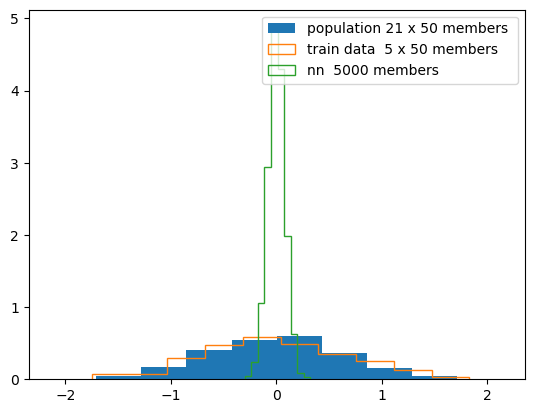

In [772]:

plt.figure()
plt.hist(ds_full_nino.sel(lead_time = lead_time).values.flatten(), density = True, histtype='stepfilled', bins = 10, label = f'population {len(ds_full_nino.ensembles)} x {len(ds_full_nino.year)} members ')
plt.hist(ds_in_nino.sel(lead_time = lead_time).values.flatten(), density = True, histtype='step', bins = 10, label = f'train data  {len(ds_in_nino.ensembles)} x {len(ds_in_nino.year)} members ')
plt.hist(nn_nino_sample.sel(year = slice(nn_year, nn_year), lead_time = lead_time).values.flatten(), density = True, histtype='step', bins = 10, label = f'nn  {len(nn_nino_sample.ensembles)} members ')
plt.legend()

Text(0, 0.5, 'Nino 3.4 index [std]')

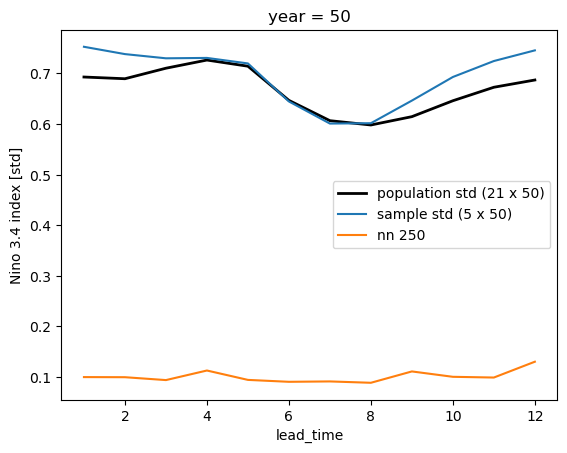

In [768]:

ds_full_nino.std(['year','ensembles']).plot(label = f'population std ({len(ds_full_nino.ensembles)} x {len(ds_full_nino.year)})', color = 'k', linewidth = 2)
ds_in_nino.std(['year','ensembles']).plot(label = f'sample std ({len(ds_in_nino.ensembles)} x {len(ds_in_nino.year)})')
nn_nino_sample.sel(year = slice(nn_year, nn_year)).std(['ensembles']).plot( label = f'nn {len(nn_nino_sample.ensembles)}')
plt.legend()

plt.ylabel('Nino 3.4 index [std]')

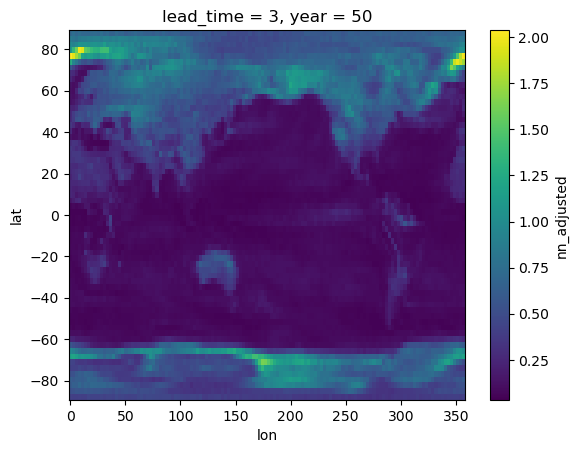

In [745]:
lead_time = 4

nn_adjusted[0,2].std(['ensembles']).plot()

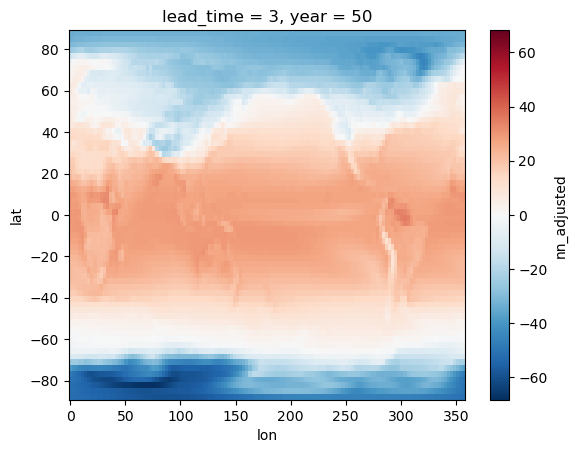

In [611]:
nn_adjusted[0,2].mean(['ensembles']).plot()

In [729]:
# nn_std = ((nn_adjusted - nn_adjusted.mean(['year','ensembles'])) / nn_adjusted.std(['year','ensembles']))
ds_std = ((ds_in- ds_in[:-1] .mean(['year','ensembles'])) / ds_in[:-1].std(['year','ensembles']))
nn_std = ((nn_adjusted - ds_in[:-1].mean(['year','ensembles'])) / ds_in[:-1].std(['year','ensembles']))

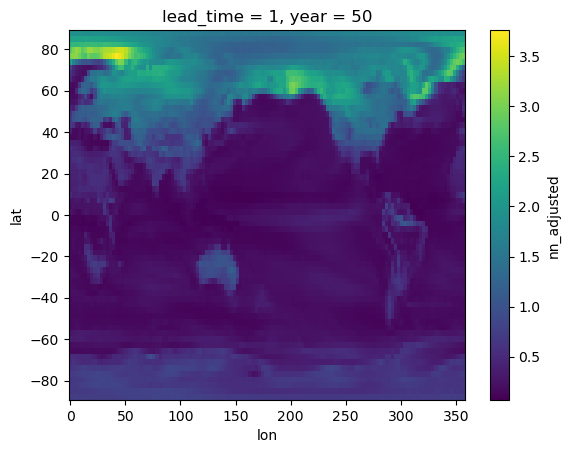

In [701]:
nn_adjusted.std('ensembles')[0,0].plot()

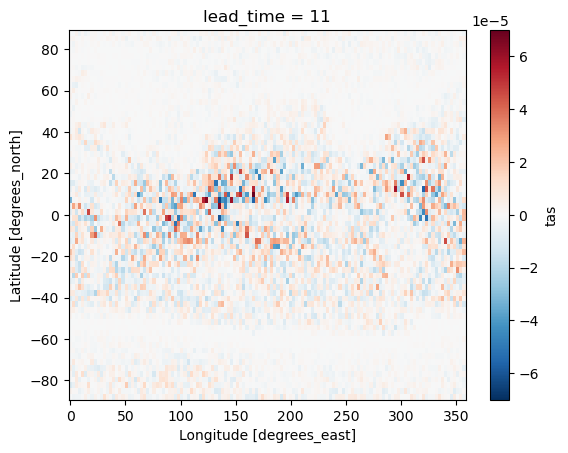

In [738]:
ds_std[:-1].mean(('ensembles','year'))[10].plot()

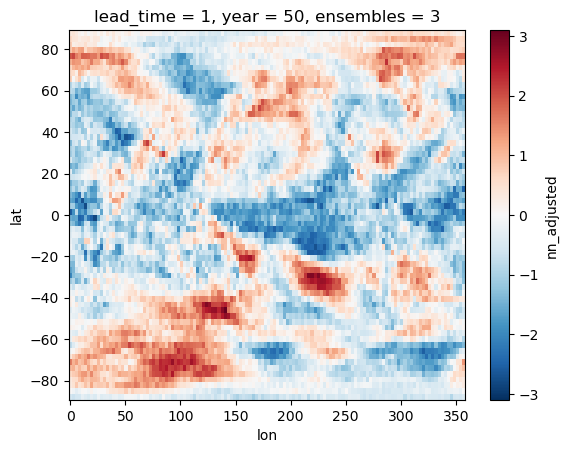

In [713]:
ds_std[0,0,2].plot()

In [195]:
ds_full = xr.open_dataset("/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/data/tas/piControl/tas_piControl_LE_0101-5112.nc")['tas'].transpose('year','lead_time','ensembles',...)
ds_in = ds_full.sel(ensembles = [ 4 , 7, 11, 12 ,20])
ds_in

<xarray.DataArray 'tas' (year: 50, lead_time: 12, ensembles: 5, lat: 64,
                         lon: 128)>
[24576000 values with dtype=float32]
Coordinates:
  * lead_time  (lead_time) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * year       (year) int64 1 2 3 4 5 6 7 8 9 10 ... 42 43 44 45 46 47 48 49 50
  * ensembles  (ensembles) int64 4 7 11 12 20

In [217]:
def normalize(ds, dim = None):
    return (ds - ds.mean(dim = dim)) / ds.std(dim = dim)

In [227]:
ds_std = normalize(ds_in, dim = ['year','ensembles'])

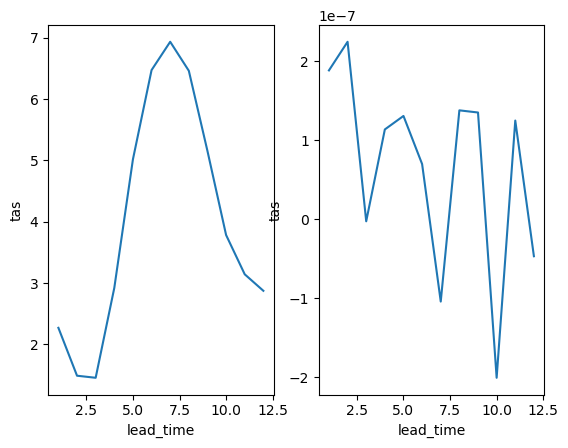

In [228]:
plt.subplot(1,2,1)
ds_in.mean(['year','lat','lon','ensembles']).plot()
plt.subplot(1,2,2)
ds_std.mean(['year','lat','lon','ensembles']).plot()


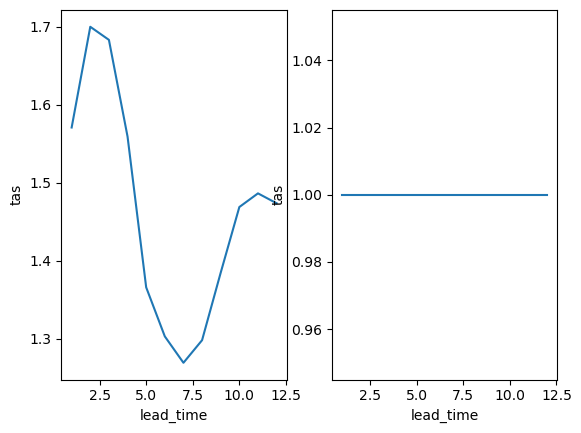

In [229]:
plt.subplot(1,2,1)
ds_in.std(['year','ensembles']).mean(['lat','lon']).plot()
plt.subplot(1,2,2)
ds_std.std(['year','ensembles']).mean(['lat','lon']).plot()

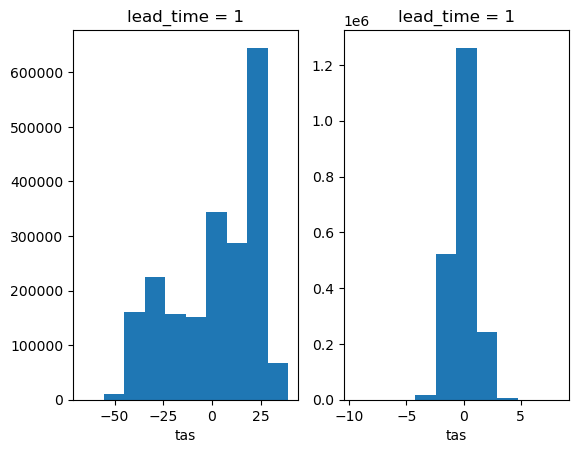

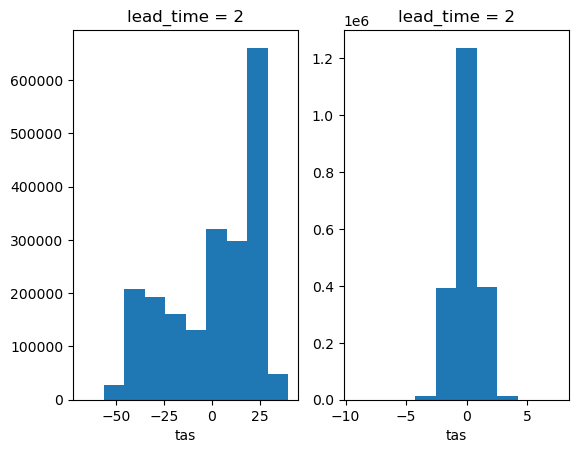

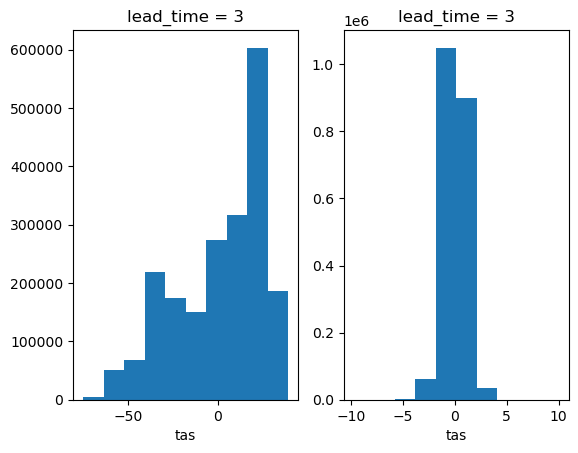

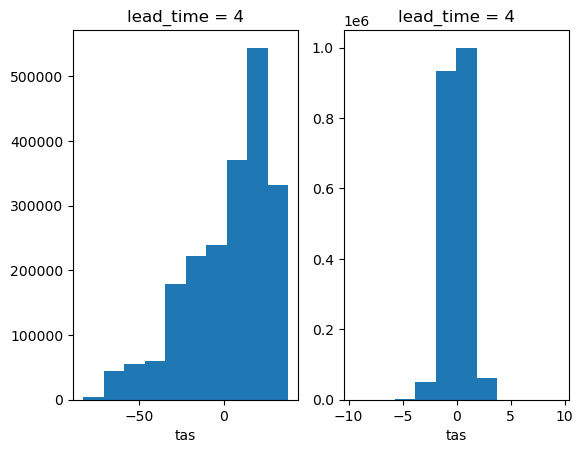

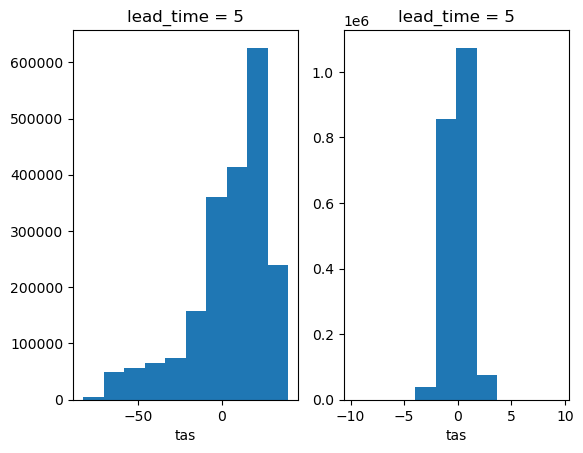

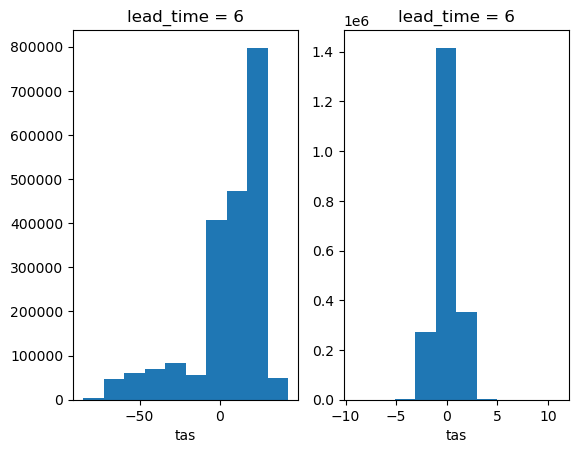

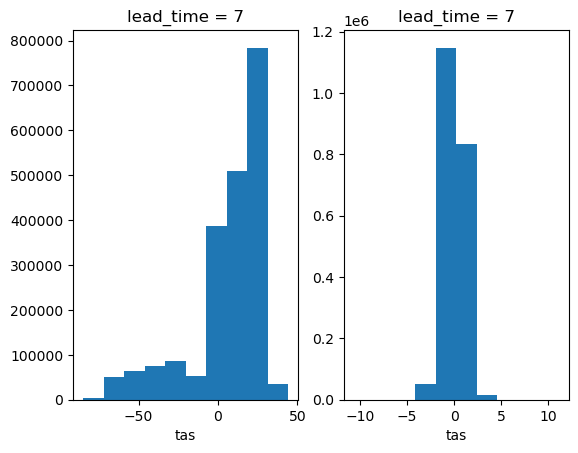

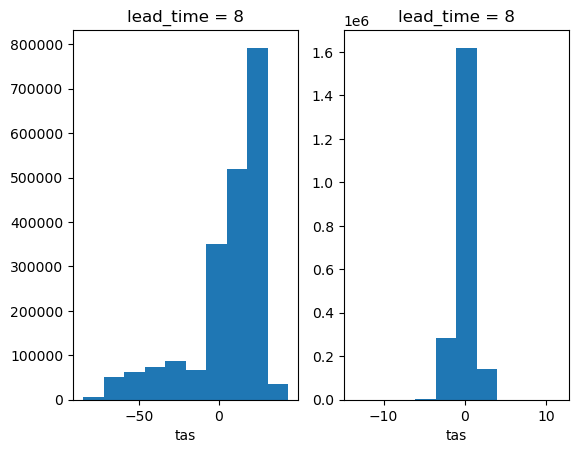

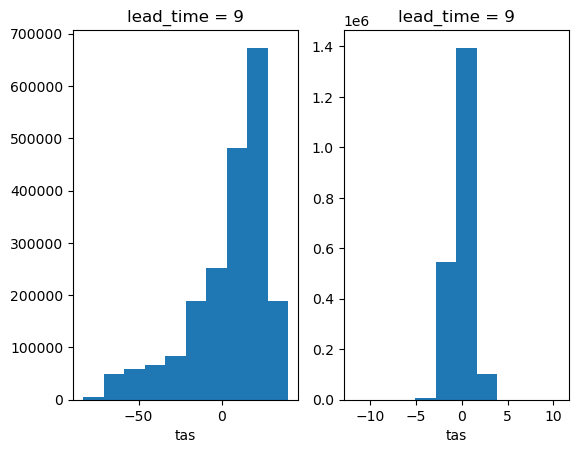

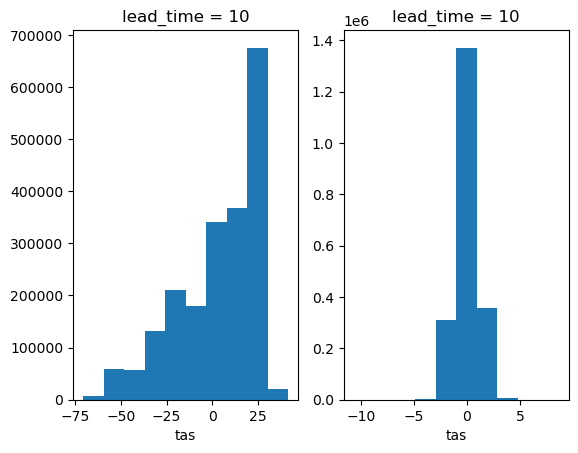

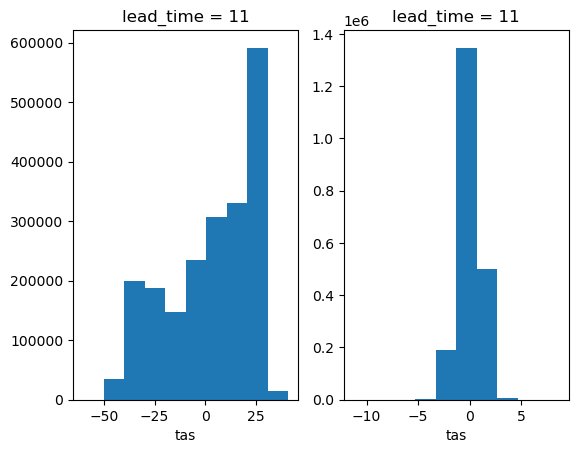

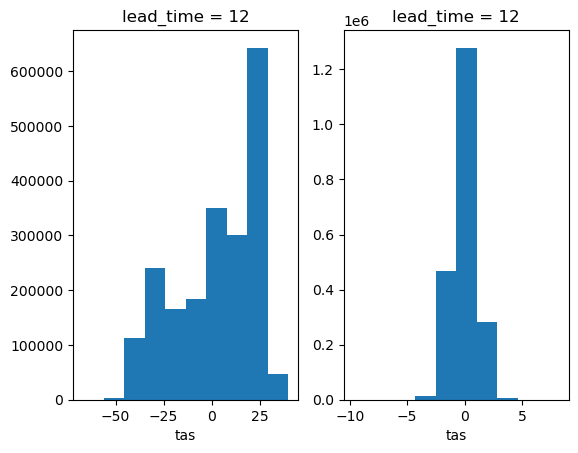

In [230]:
for i in np.arange(1,13):
    plt.figure()
    plt.subplot(1,2,1)
    ds_in.sel(lead_time = i).plot()
    plt.subplot(1,2,2)
    ds_std.sel(lead_time = i).plot()

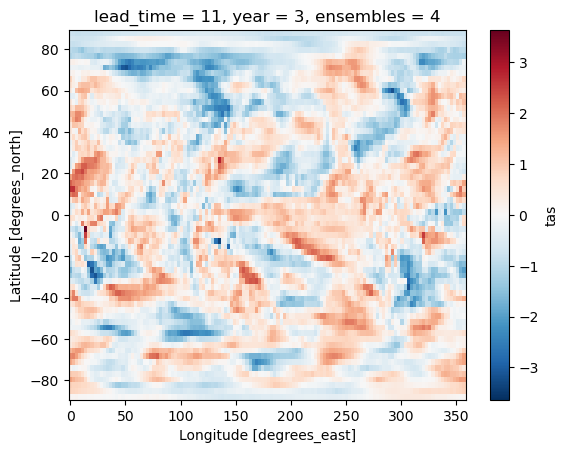

In [235]:
ds_std[2,10,0].plot()